<a href="https://colab.research.google.com/github/Will-est/PPO-From-Scratch/blob/main/PPO_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install numpy==1.23.5
# !pip install --upgrade numpy

In [ ]:
# import statments
import argparse
import os
import random
import time

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [55]:
import matplotlib.pyplot as plt

def plot_losses(policy_loss, entropy_loss, value_loss, dones_counts):
  # Plotting the losses and dones count
  fig, axs = plt.subplots(4, 1, figsize=(10, 12))

  # Plot Policy Loss
  axs[0].plot(policy_losses)
  axs[0].set_ylabel("Policy Loss")
  axs[0].set_title("Training Progress")
  axs[0].grid(True)

  # Plot Entropy Loss
  axs[1].plot(entropy_losses)
  axs[1].set_ylabel("Entropy Loss")
  axs[1].grid(True)

  # Plot Value Loss
  axs[2].plot(value_losses)
  axs[2].set_ylabel("Value Loss")
  axs[2].grid(True)

  # Plot Dones Count
  axs[3].plot(dones_counts)
  axs[3].set_ylabel("Number of Dones")
  axs[3].set_xlabel("Rollout")
  axs[3].grid(True)

  plt.tight_layout()
  plt.show()

<>:114: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:114: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipython-input-56-1036811794.py:114: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(i%10 is 0) : print(f"We are {((1-frac)*100):.2f}% of the way there!")


We are 0.00% of the way there!


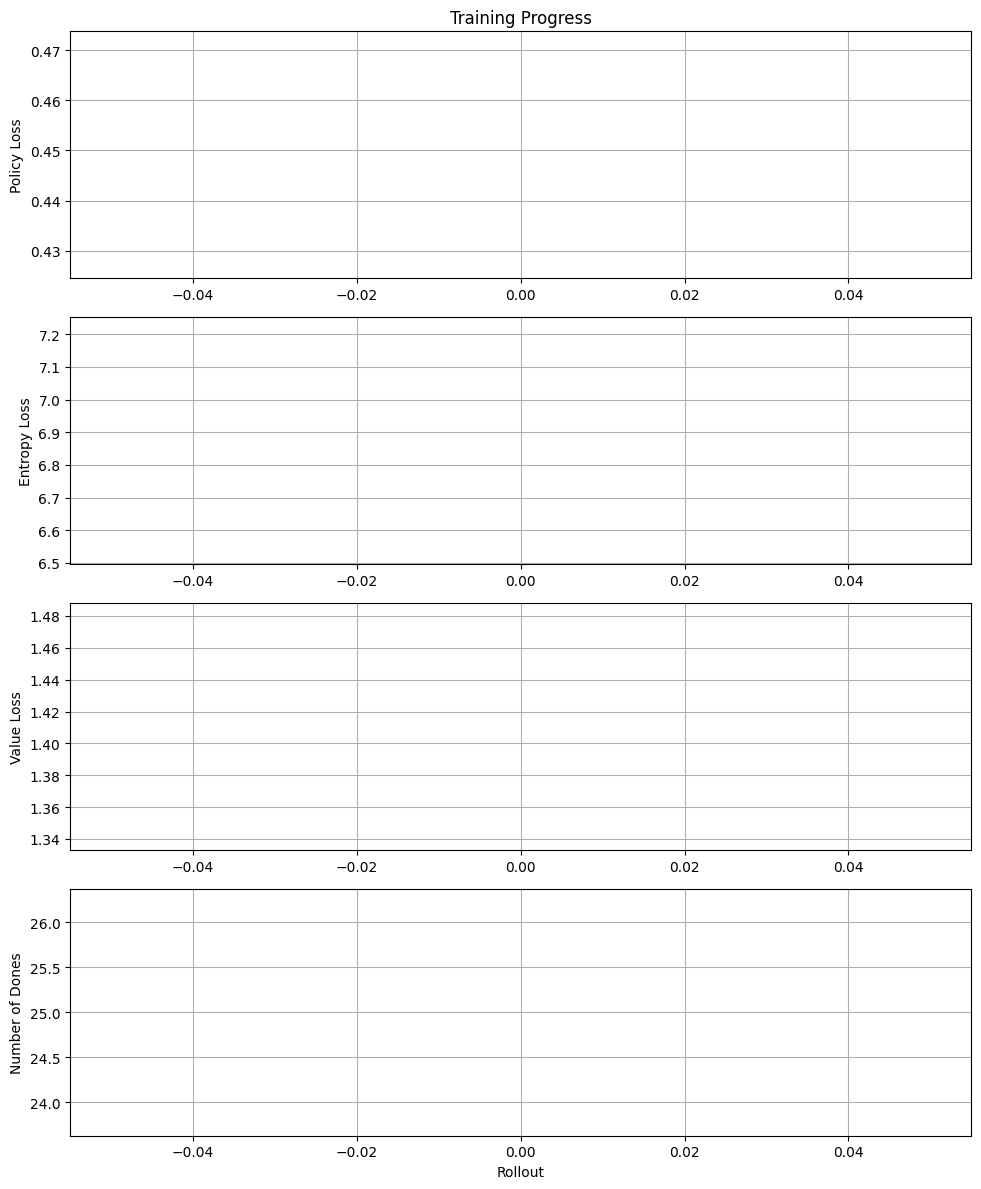

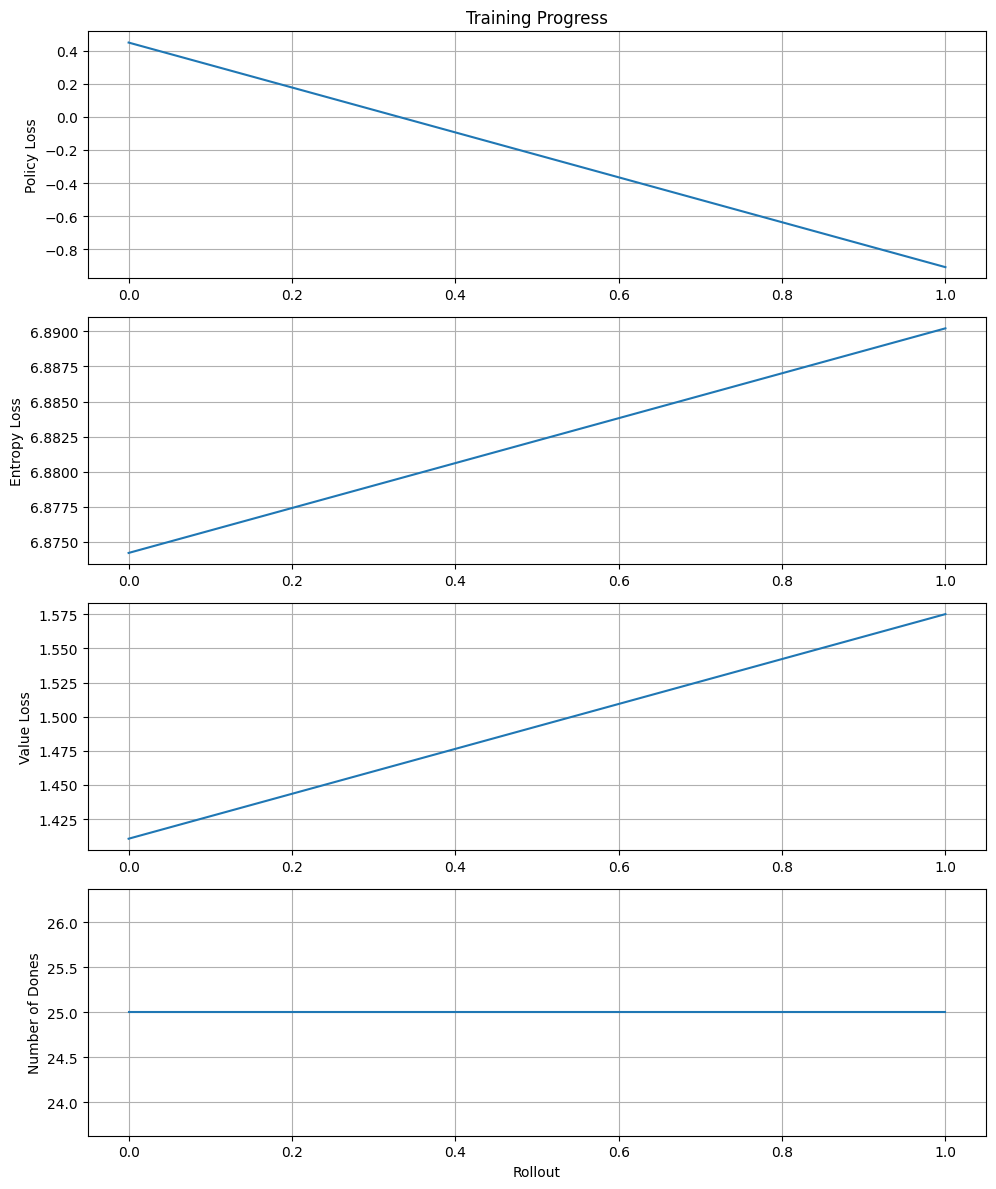

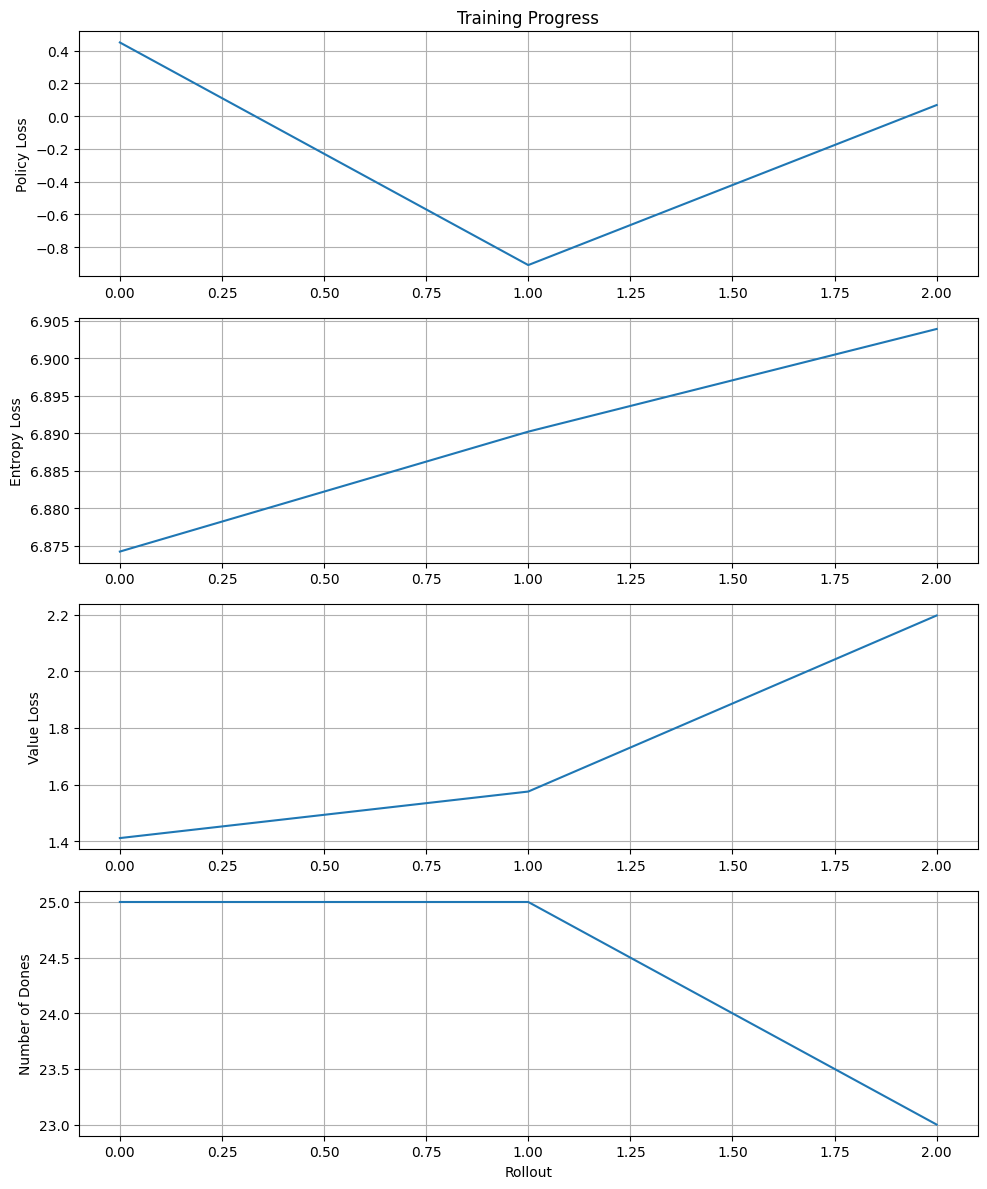

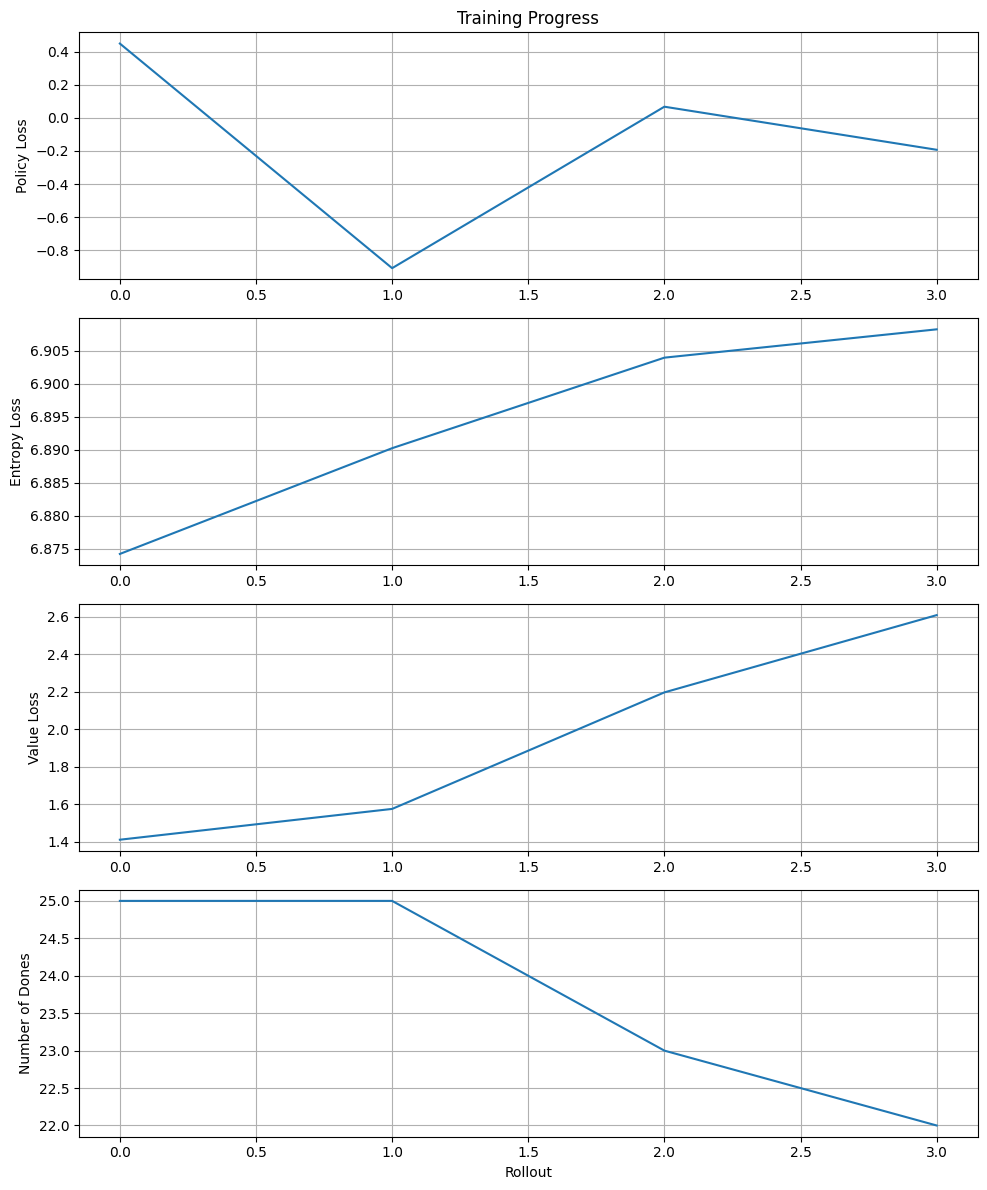

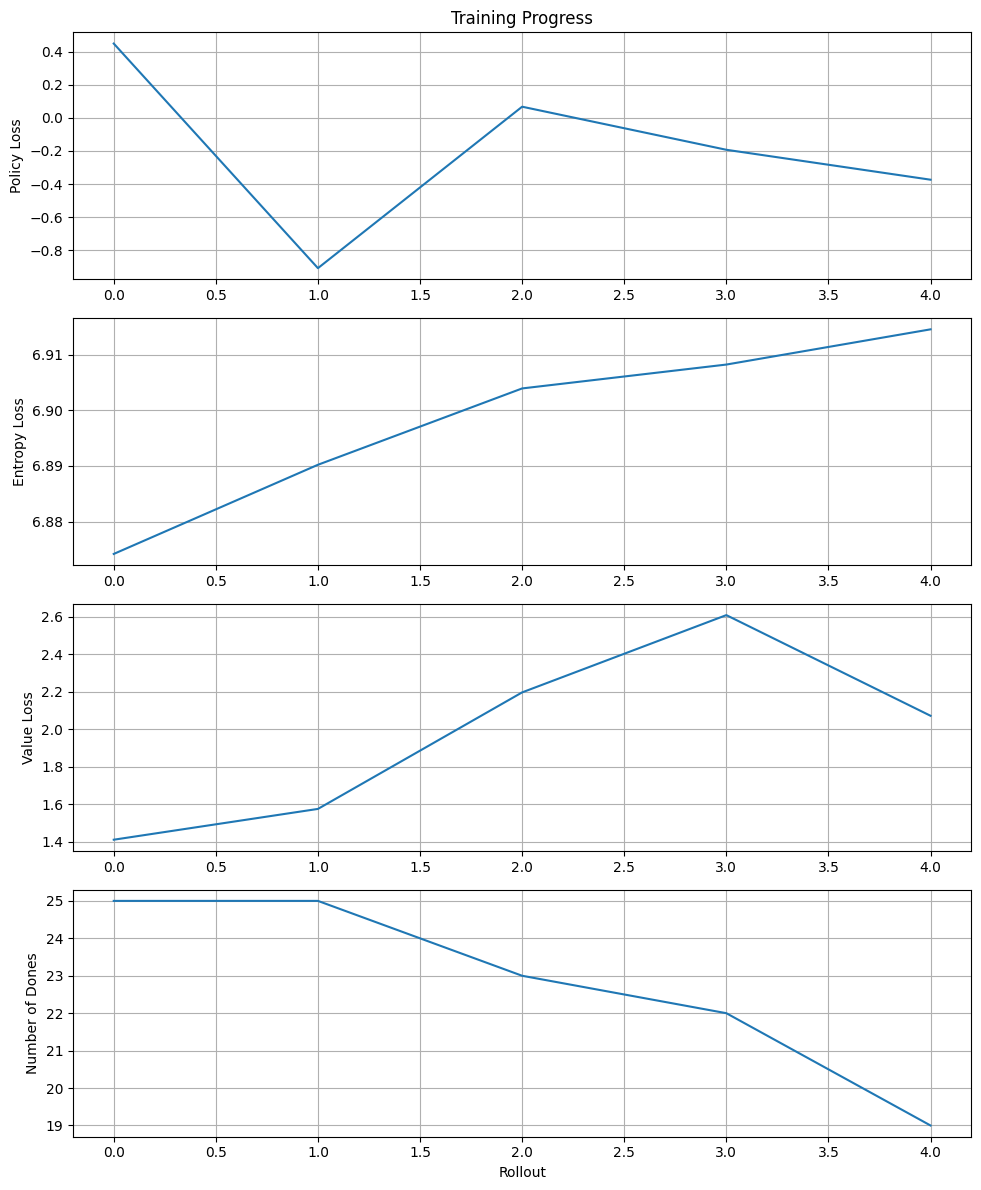

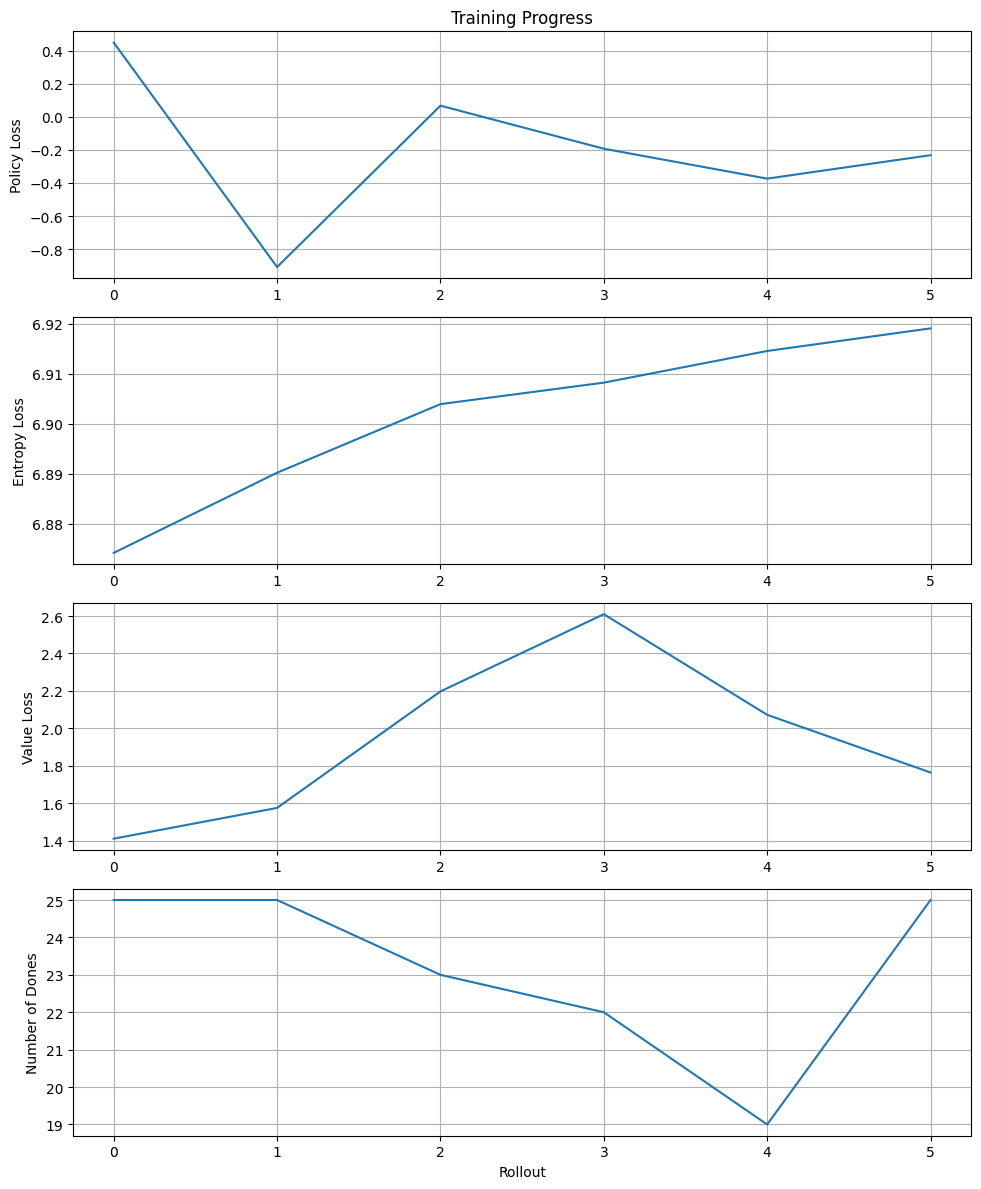

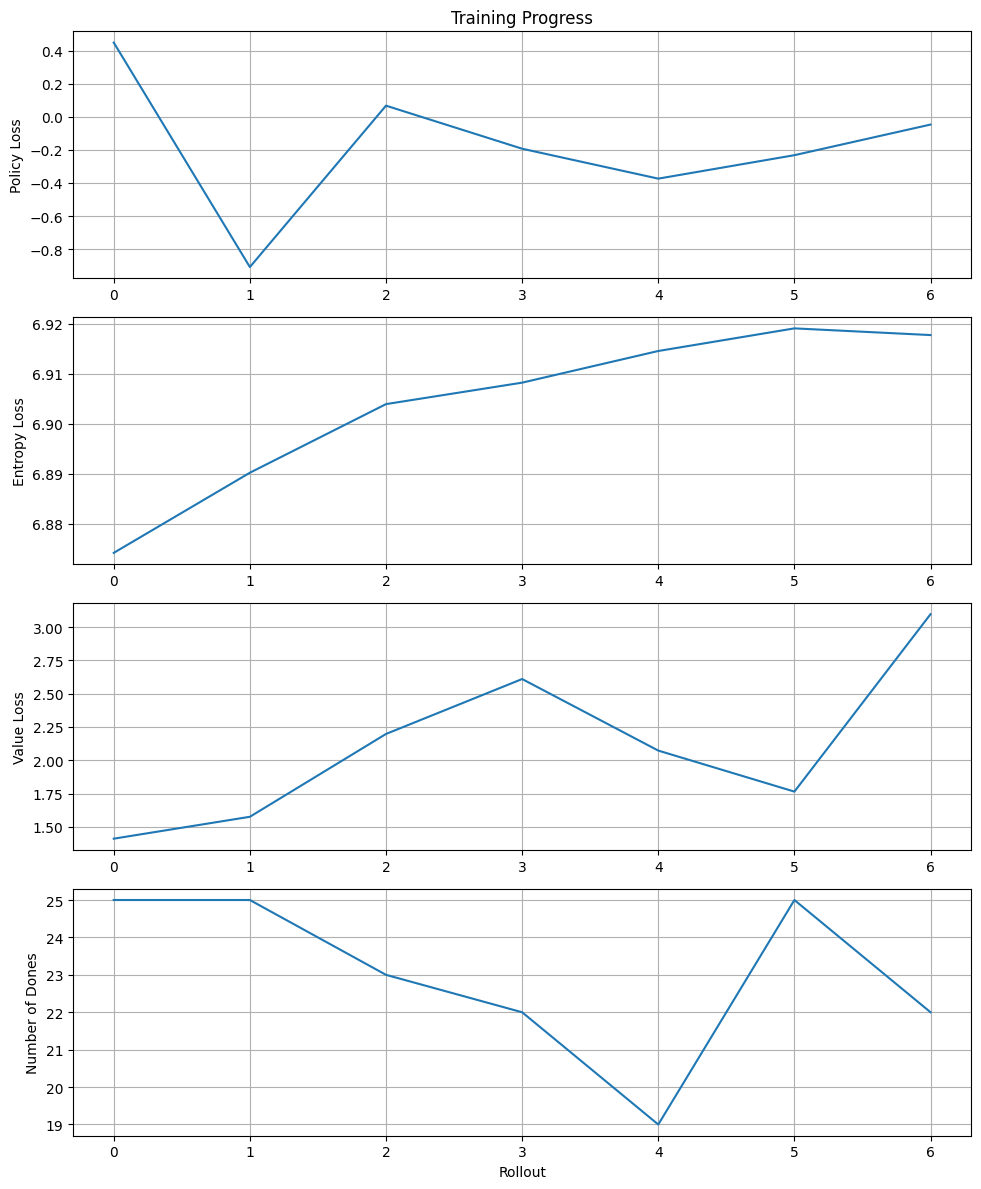

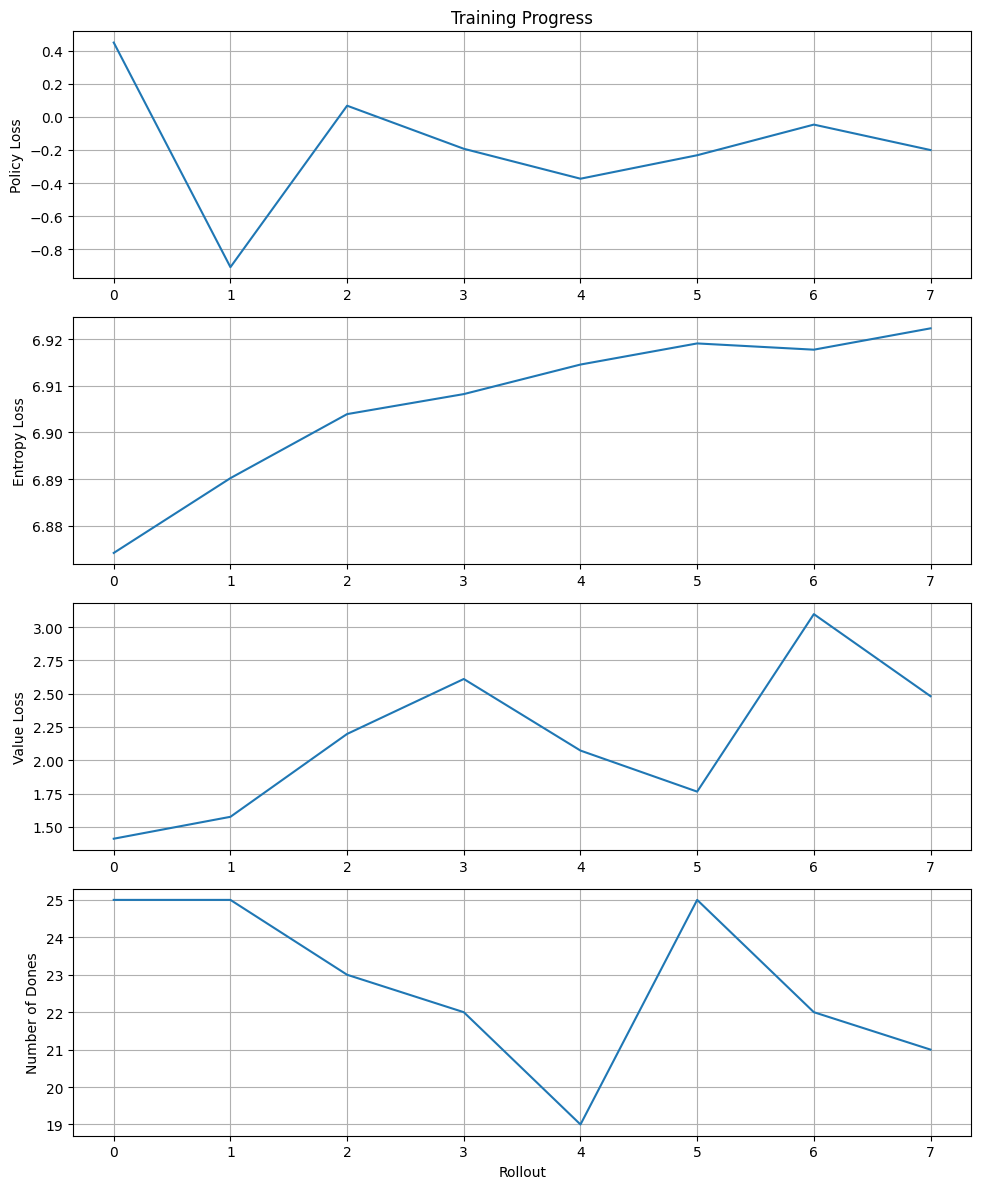

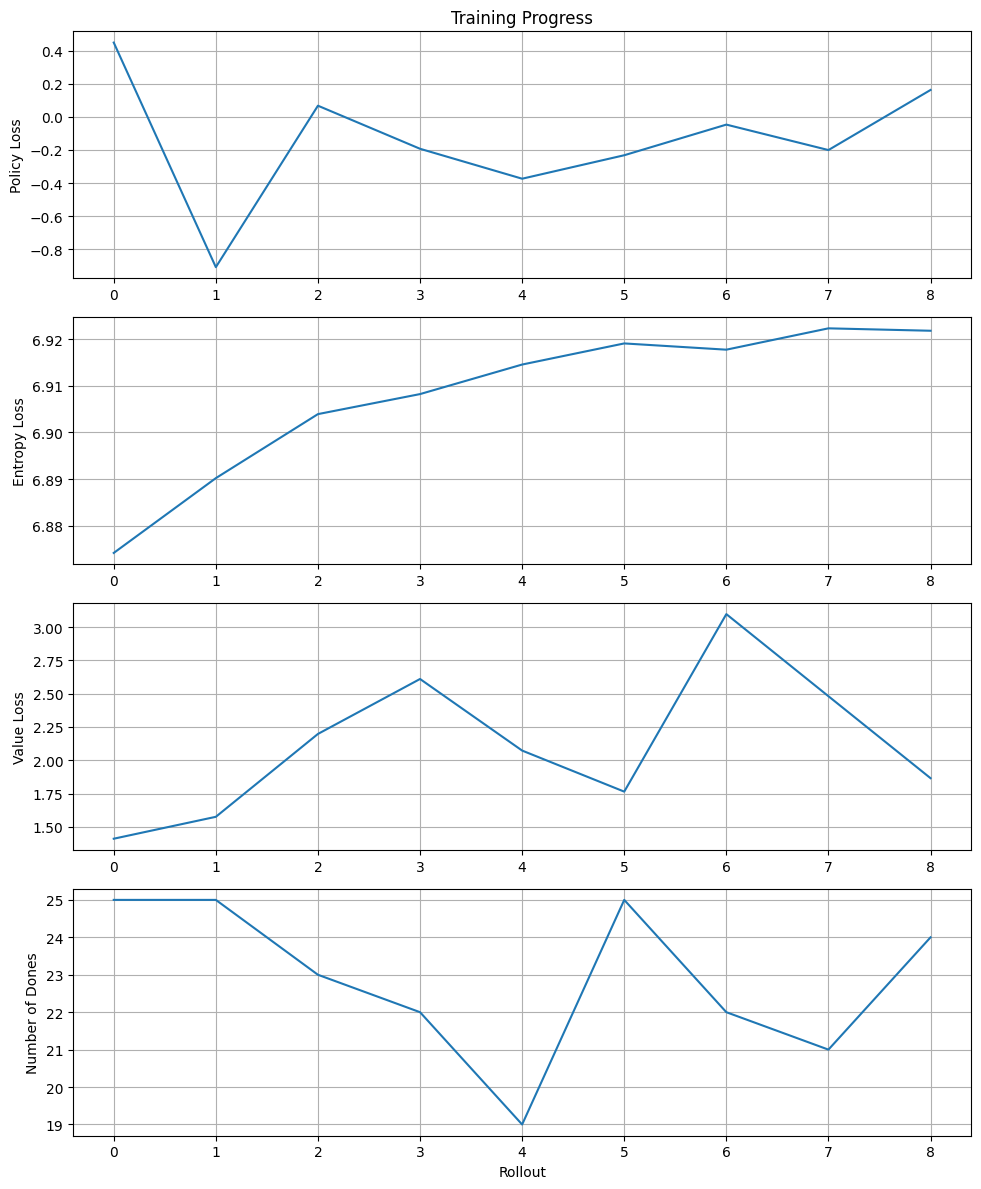

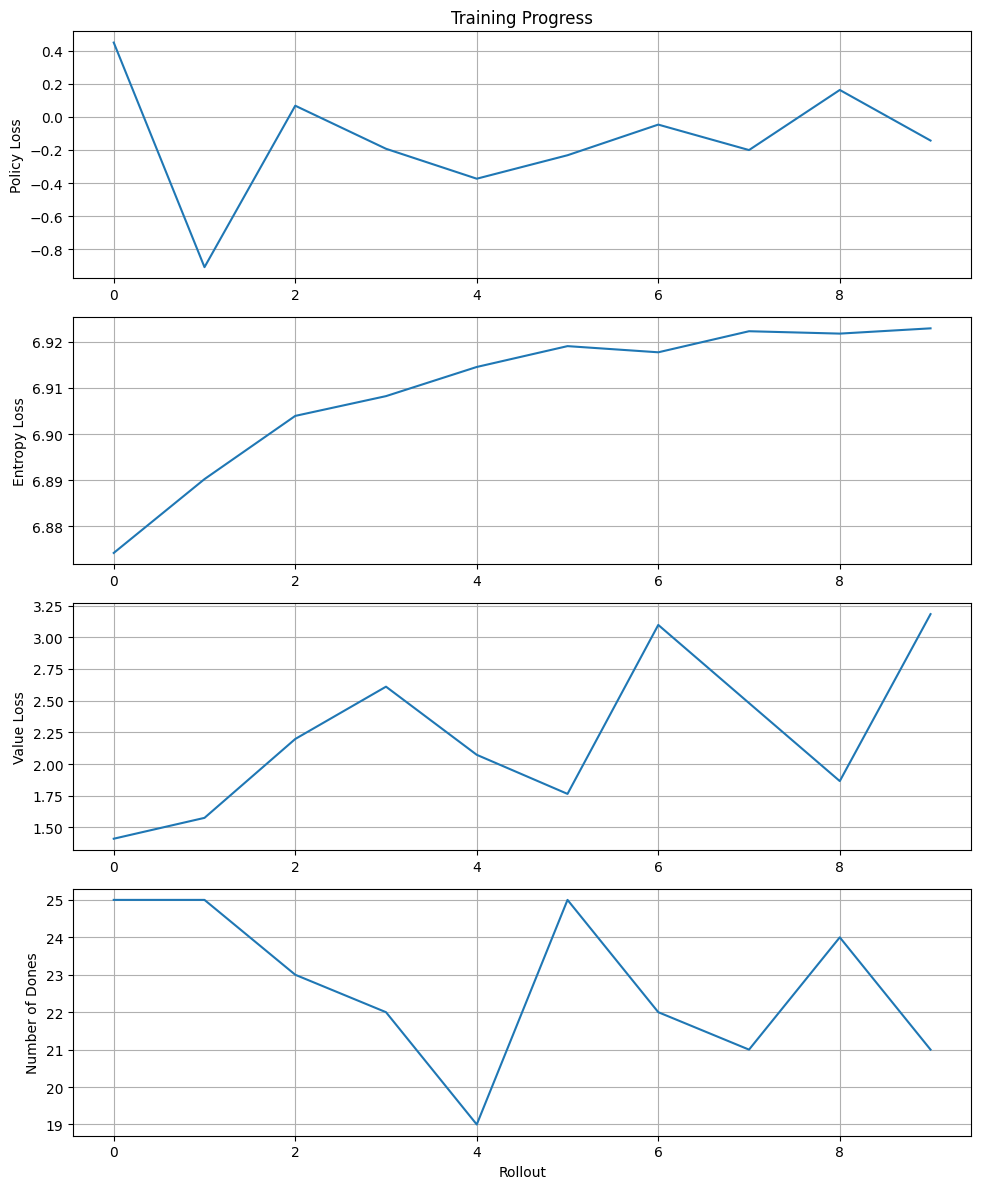

We are 2.50% of the way there!


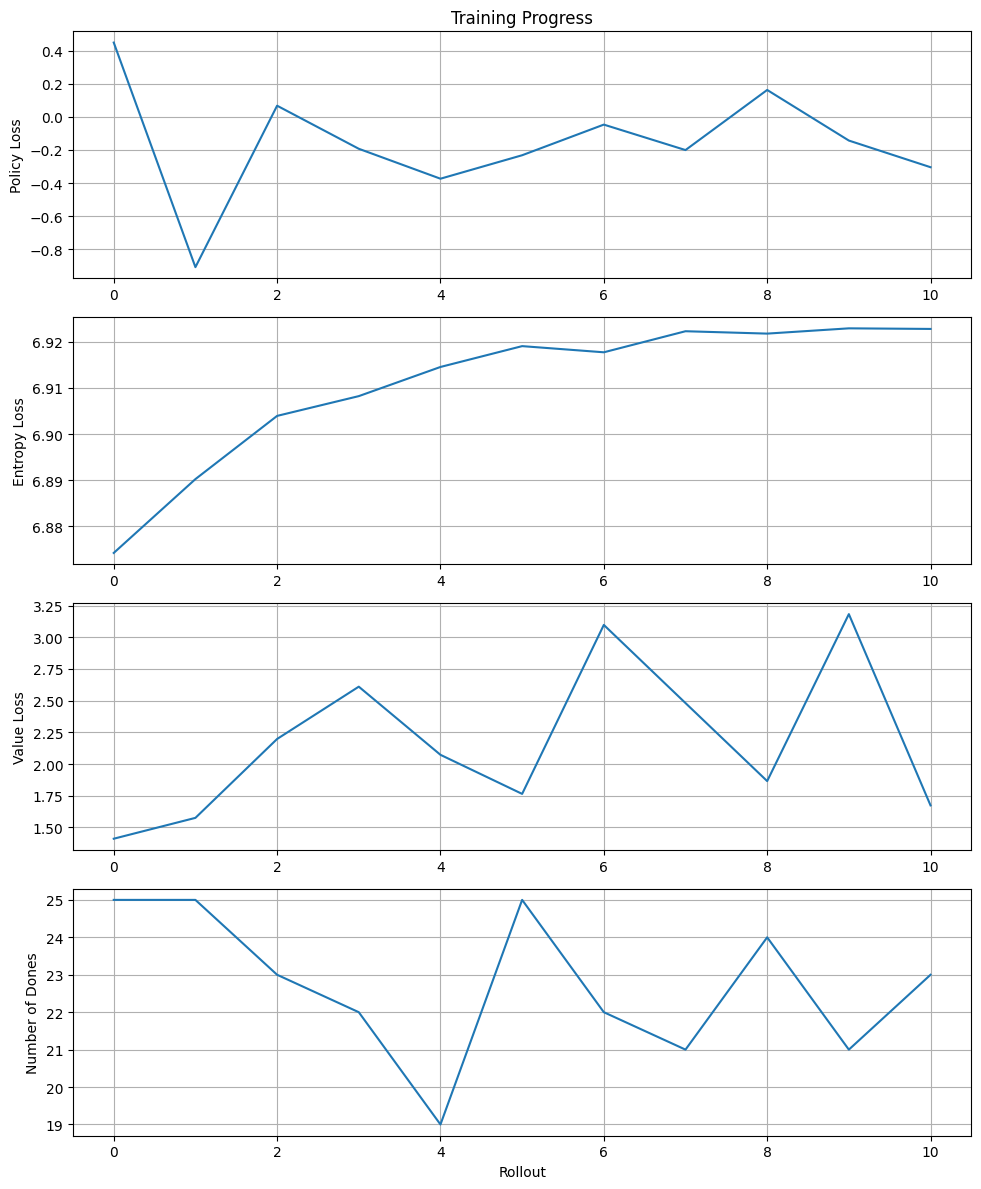

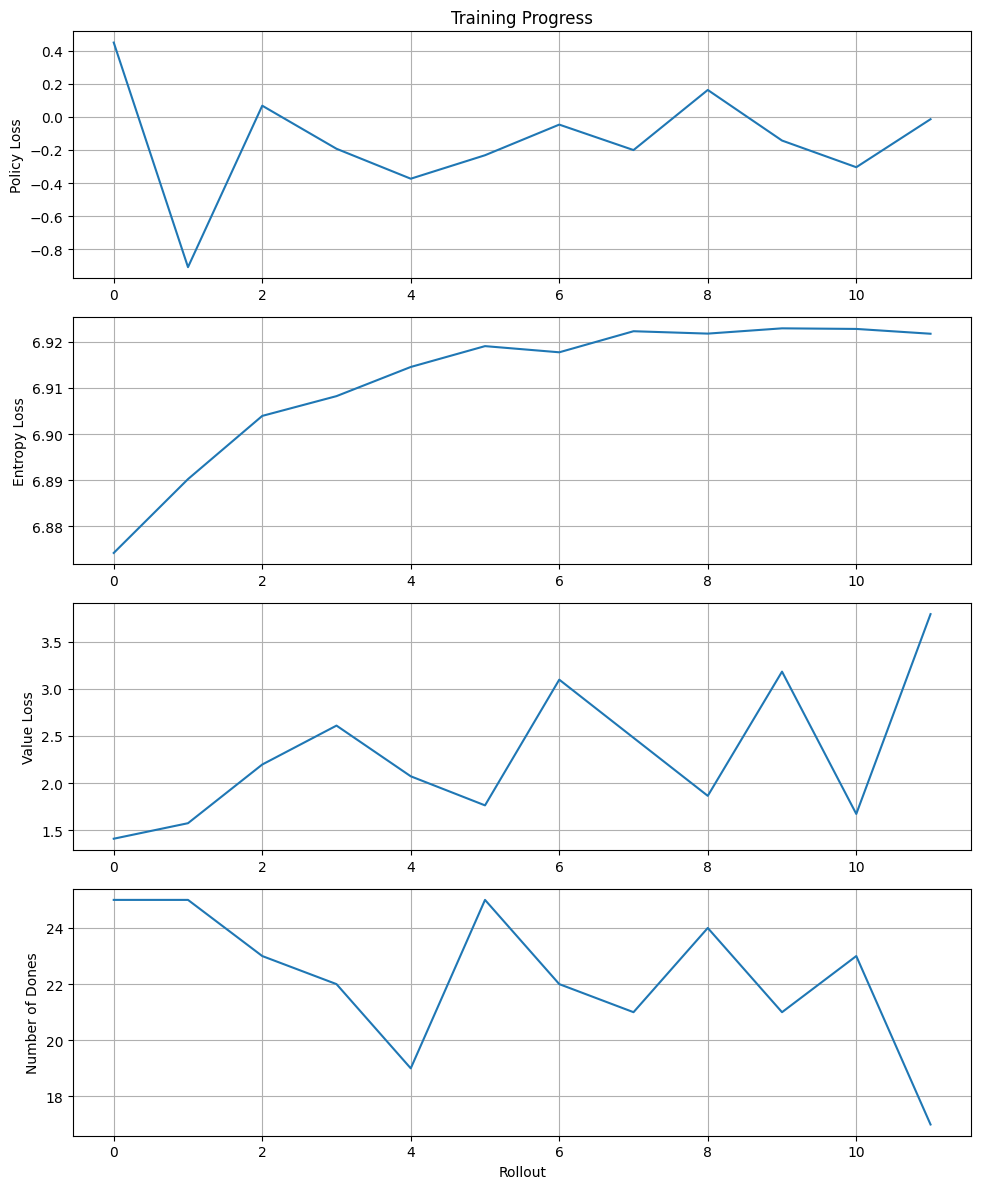

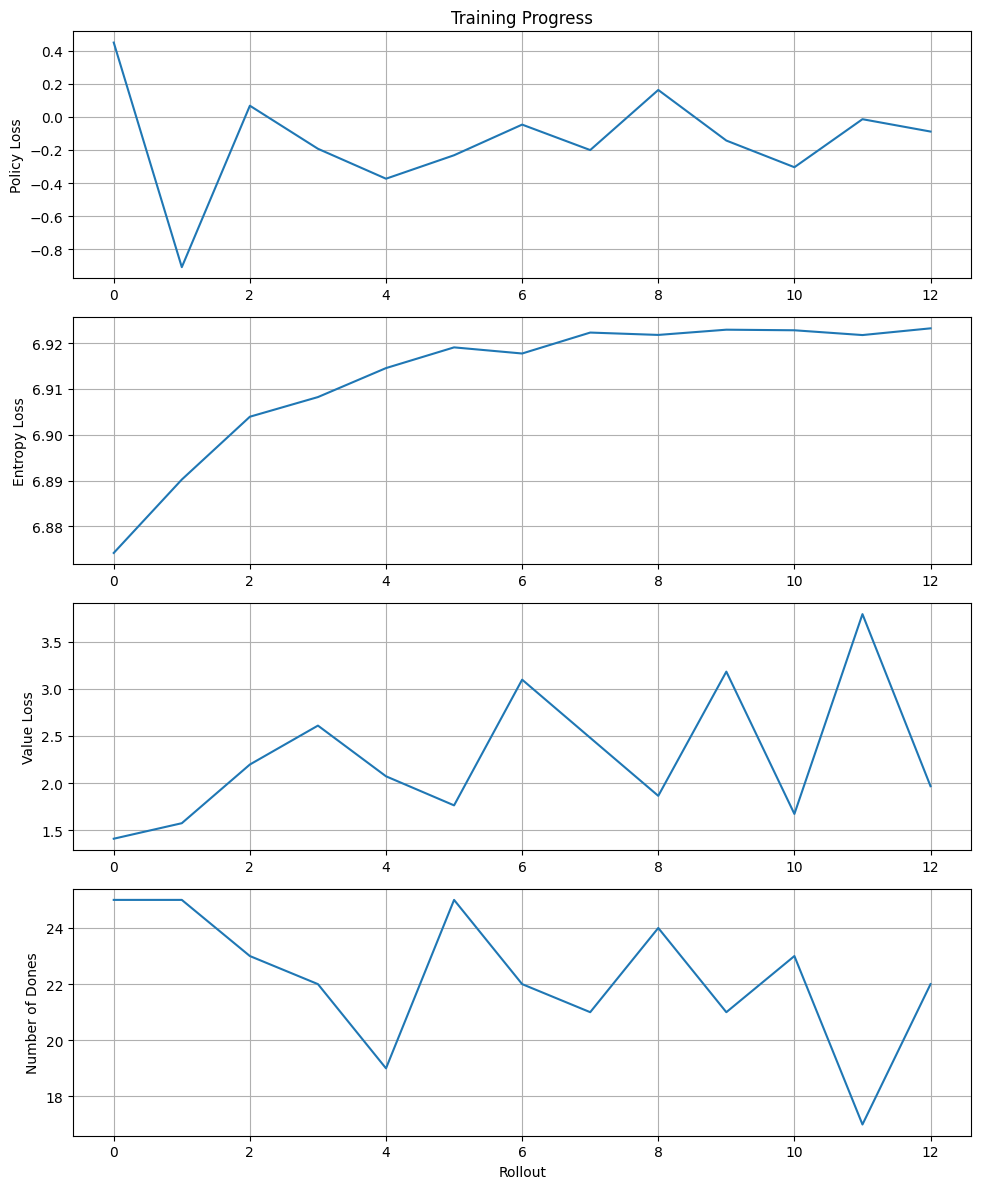

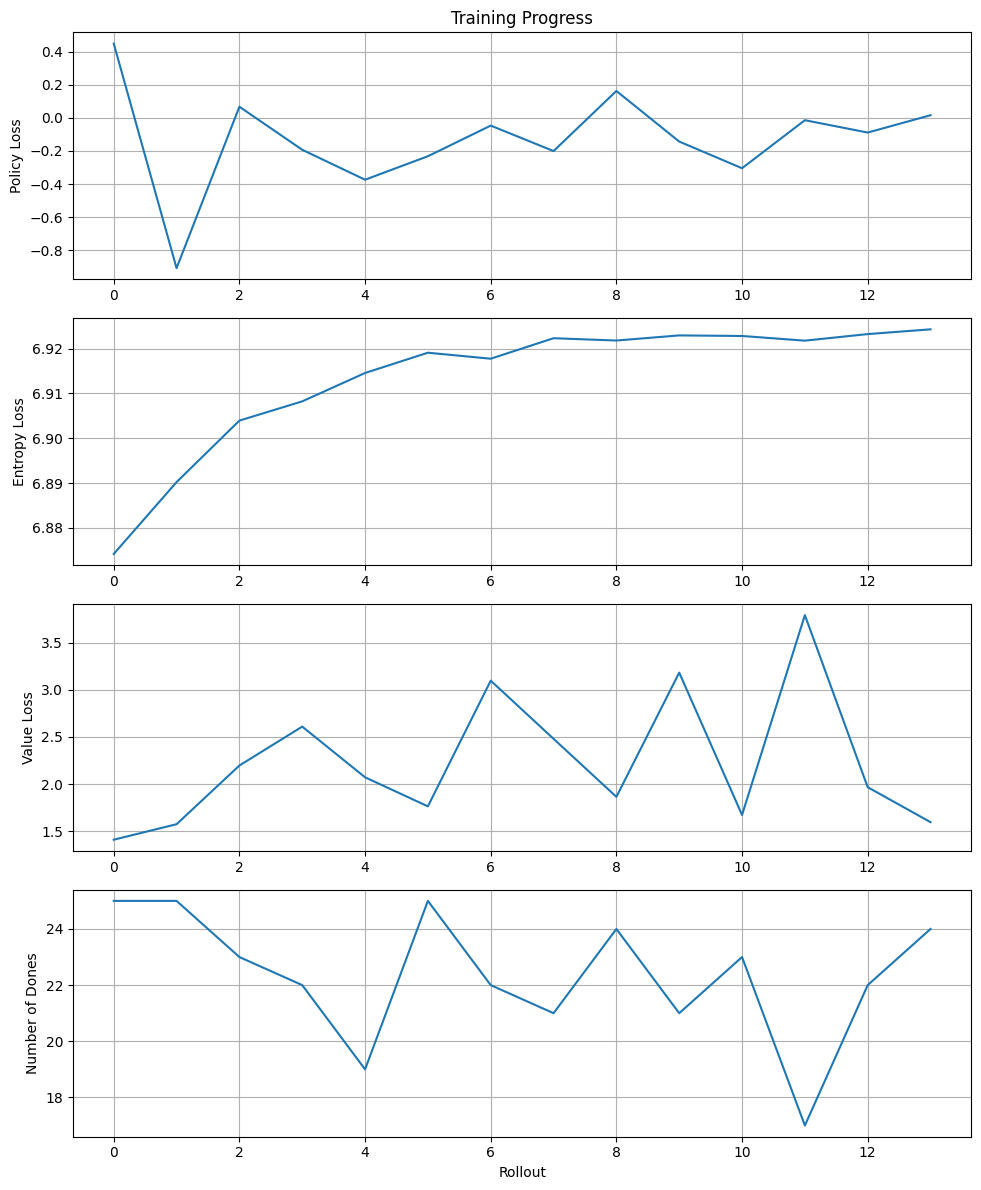

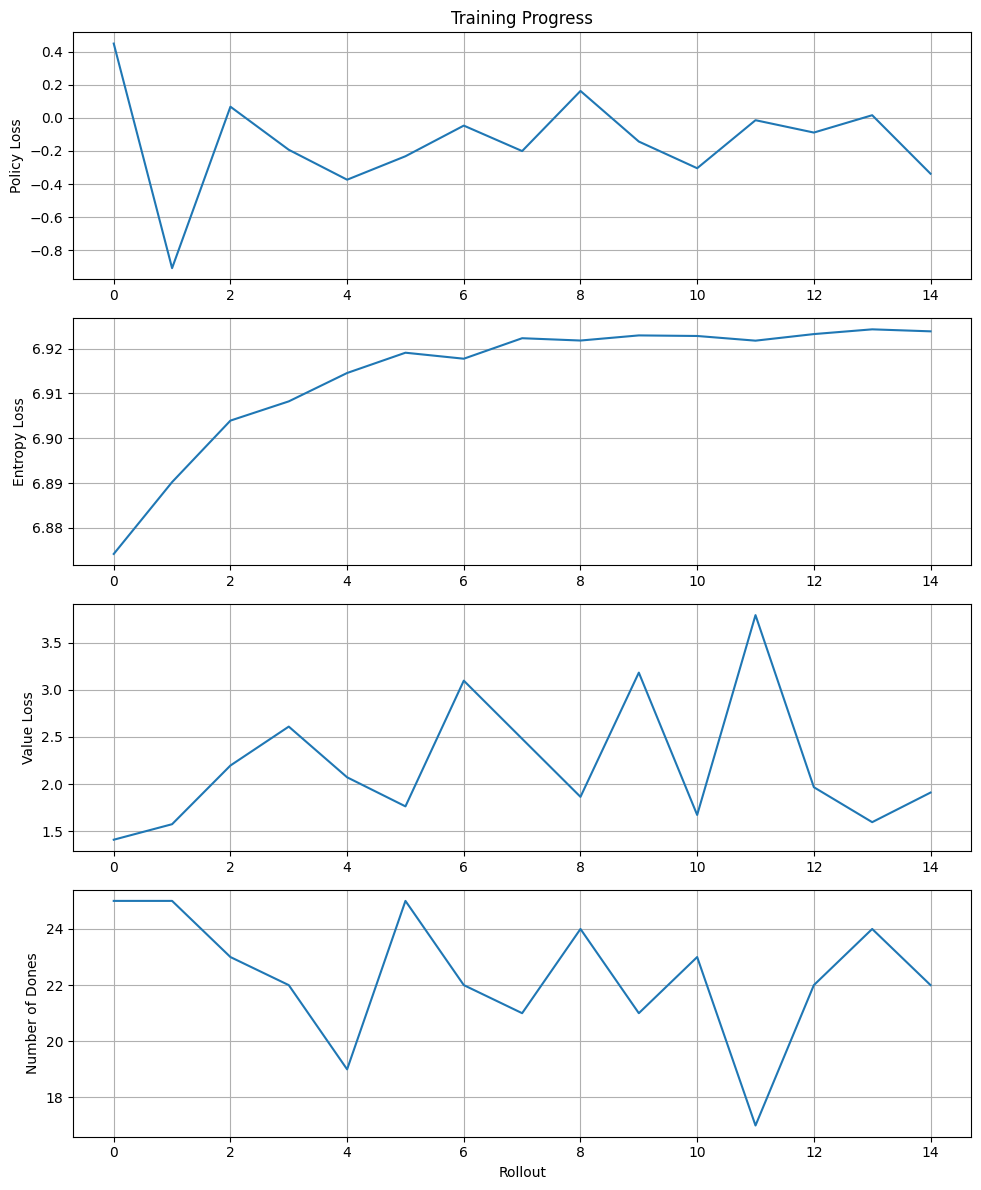

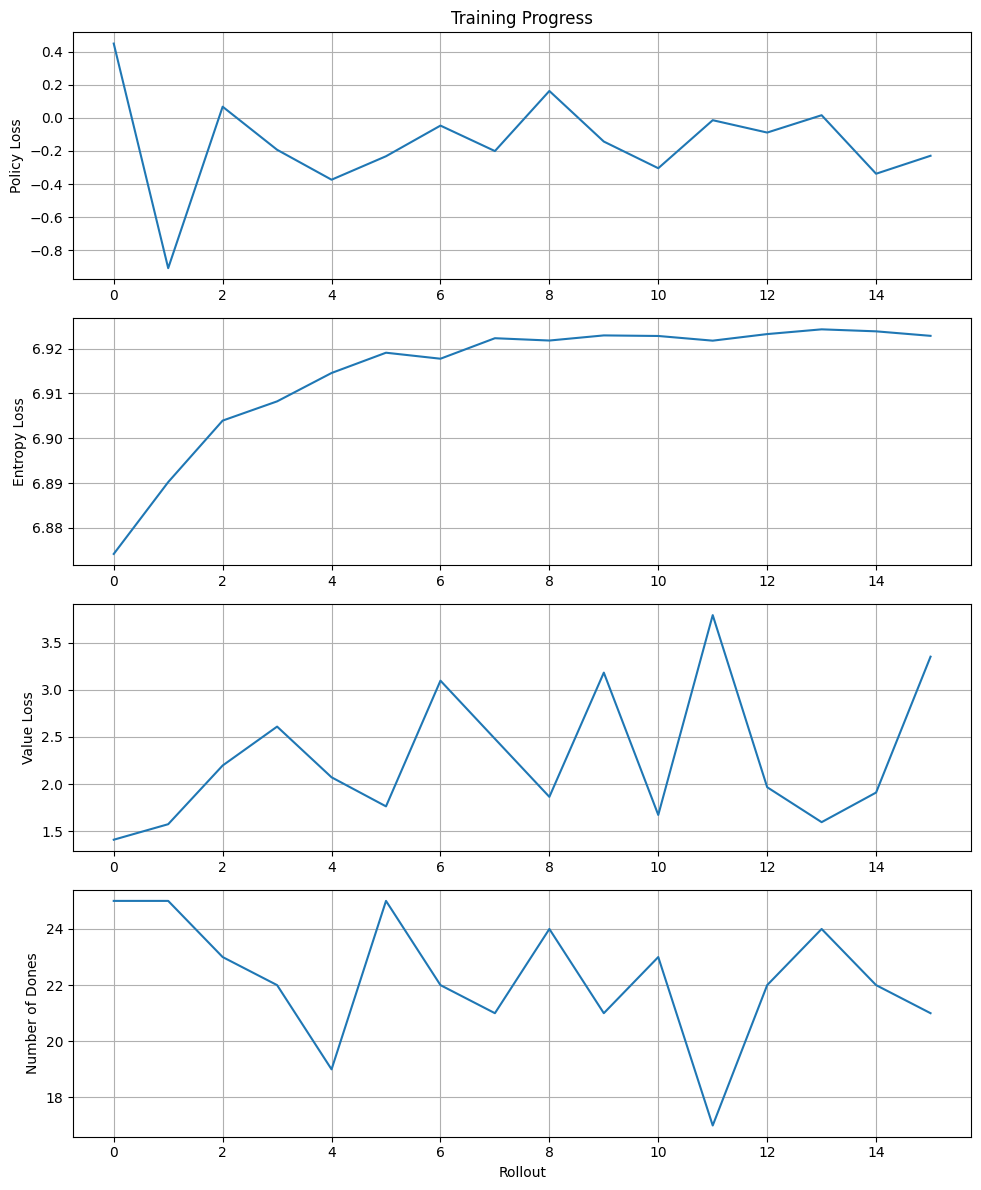

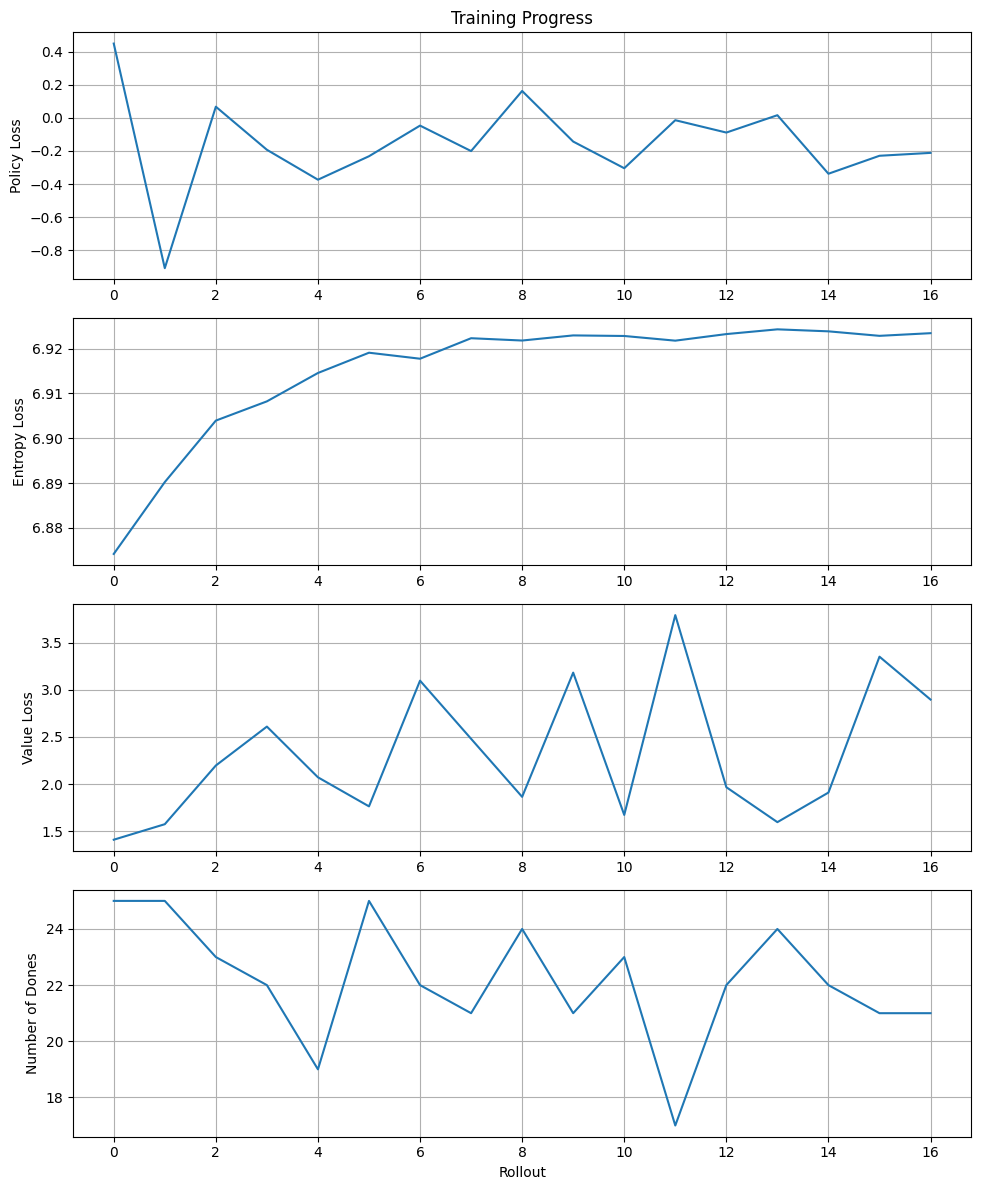

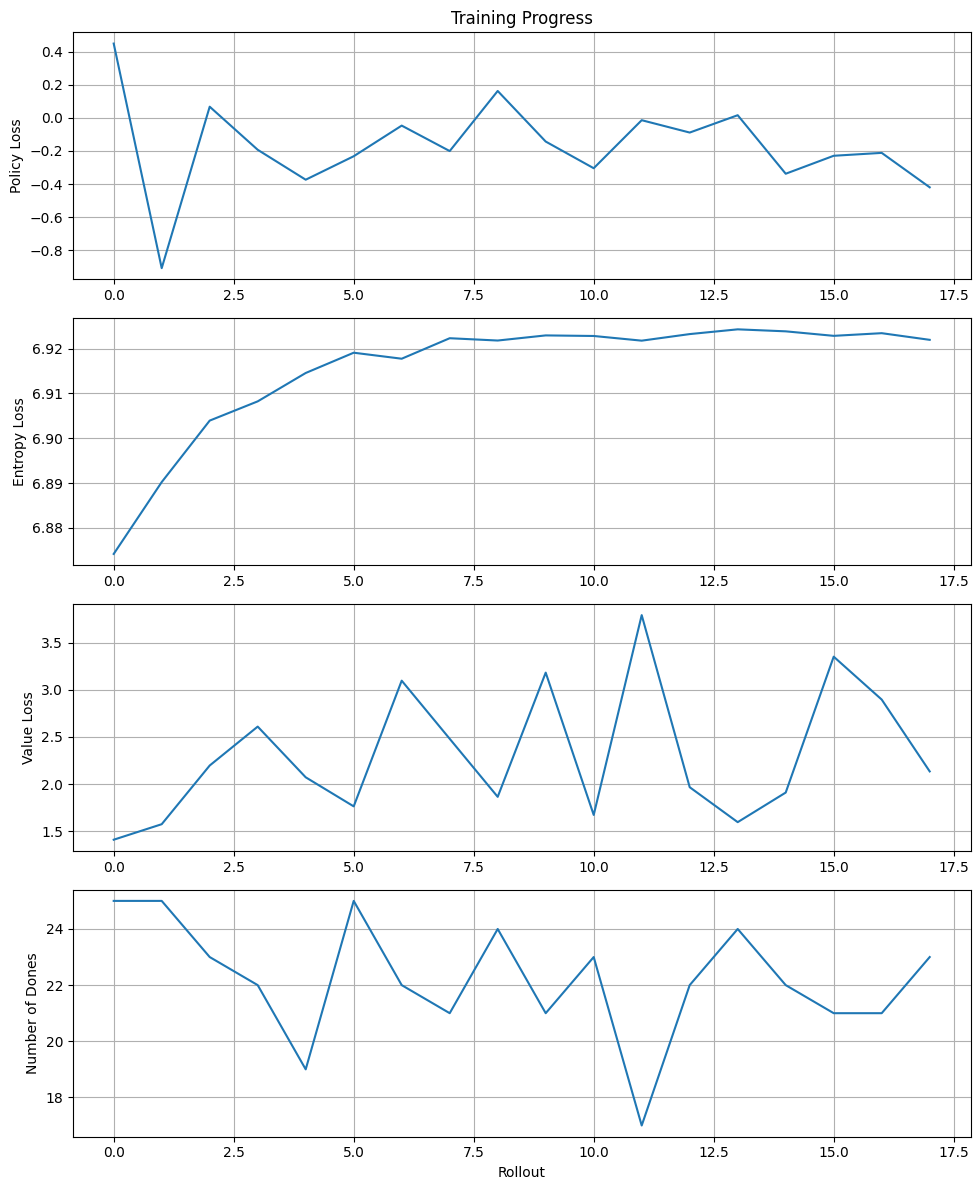

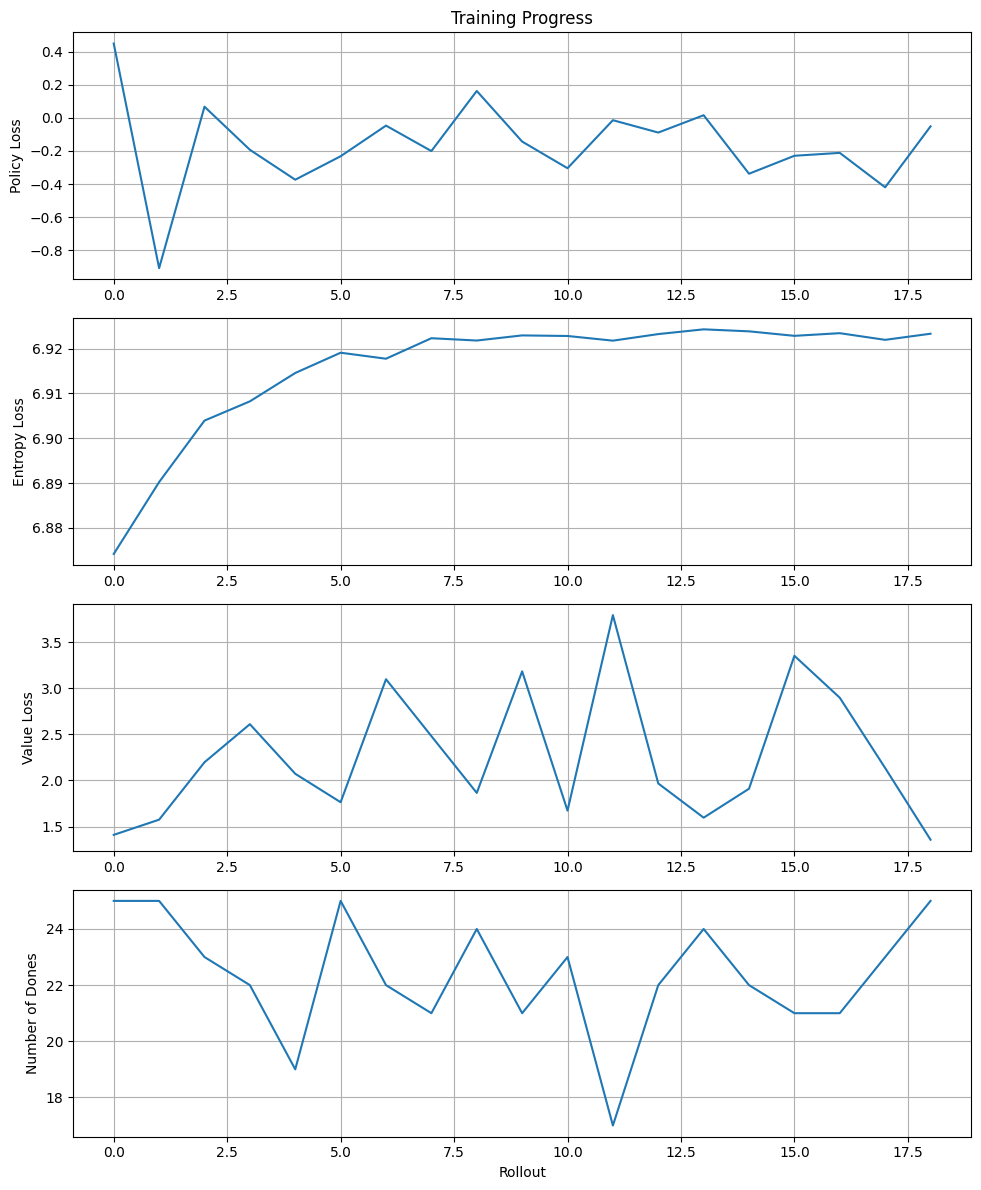

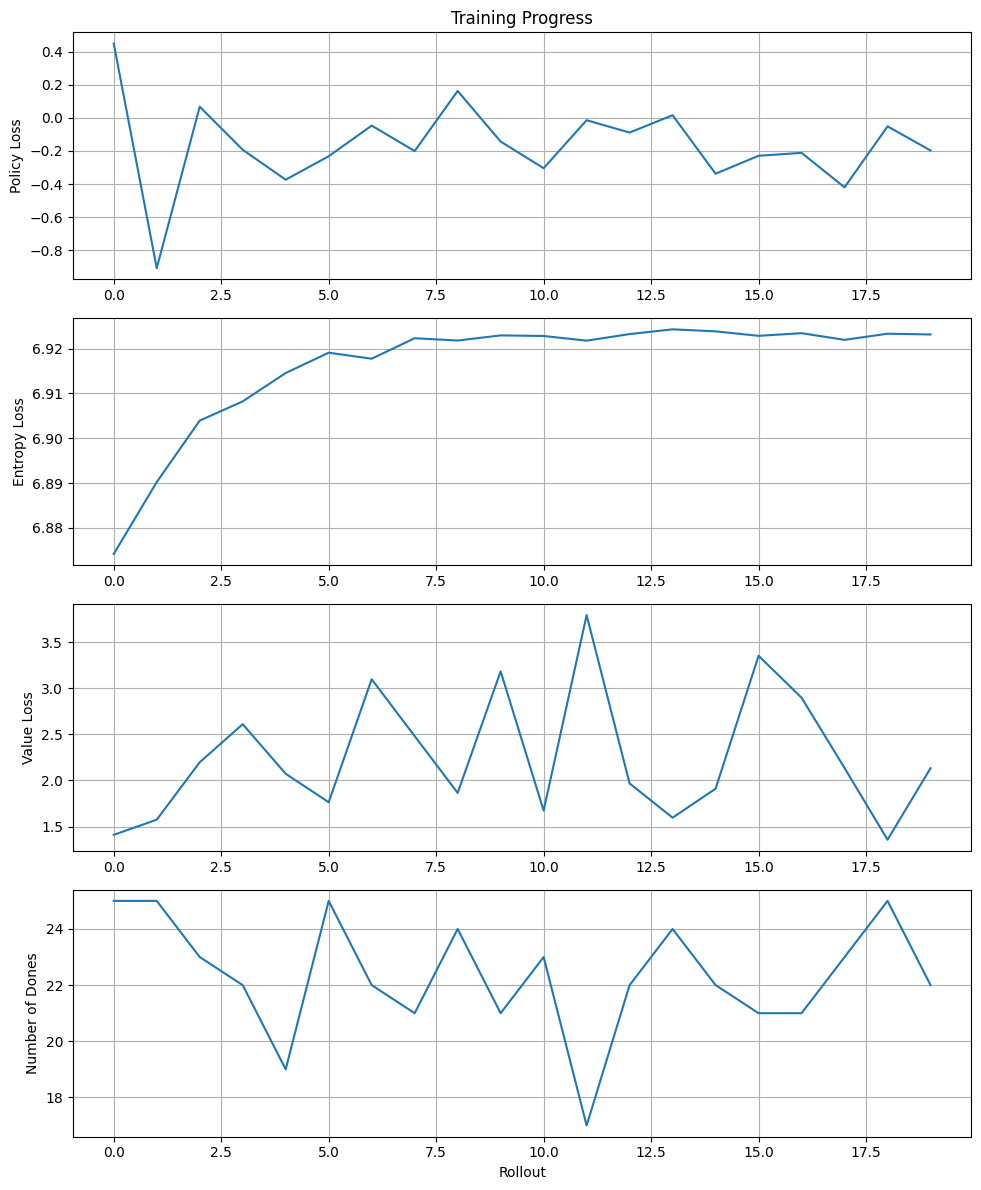

We are 5.00% of the way there!


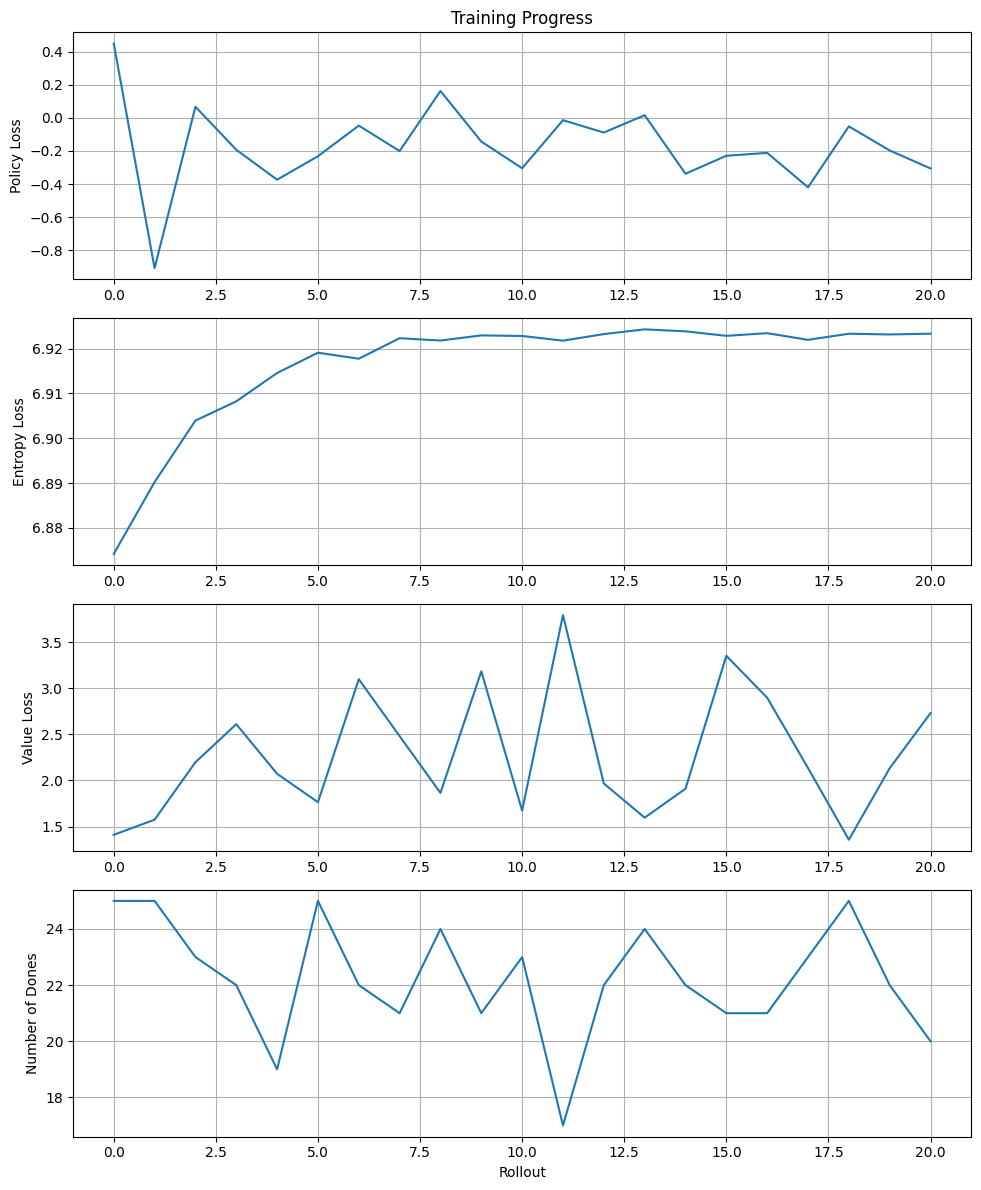

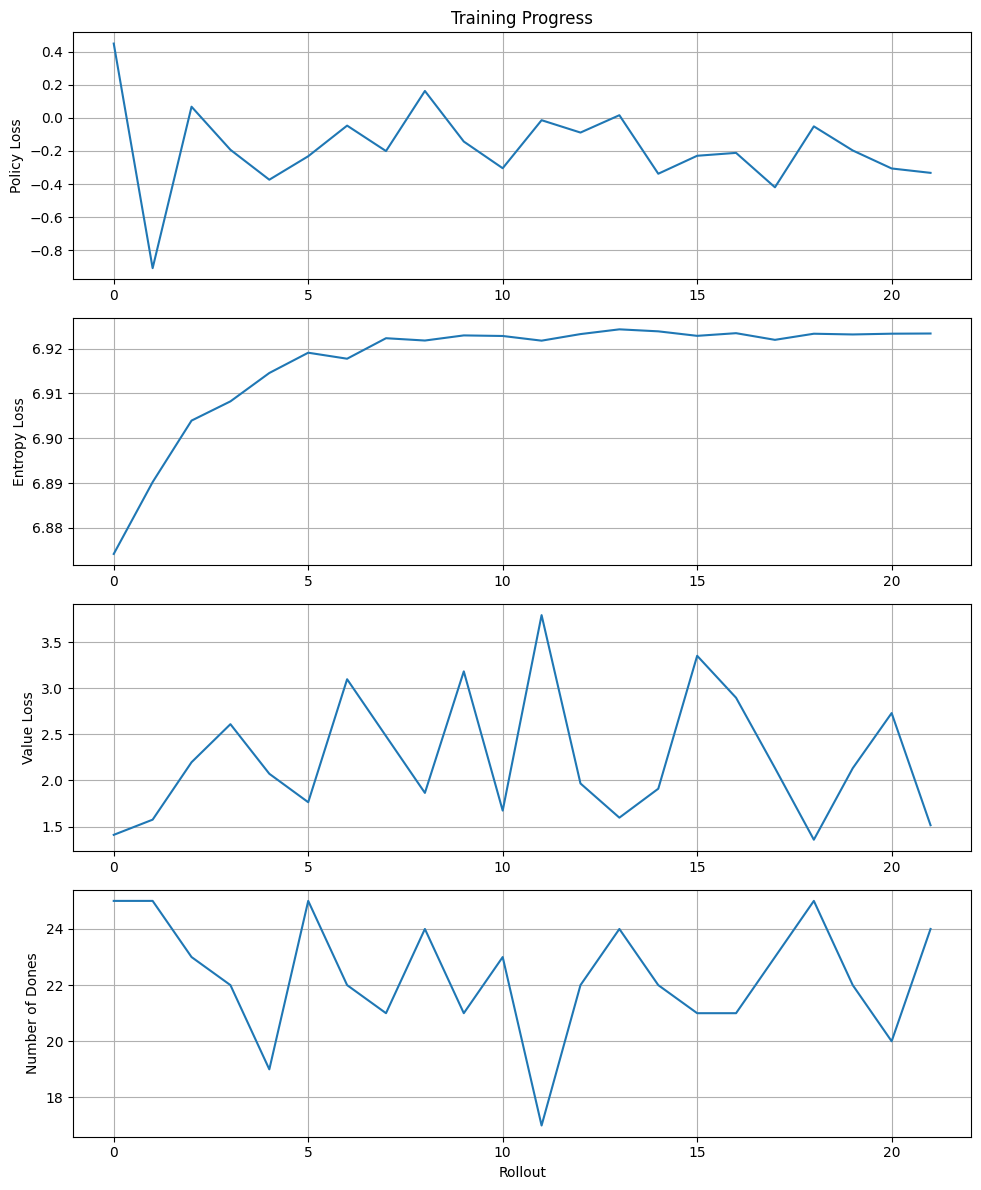

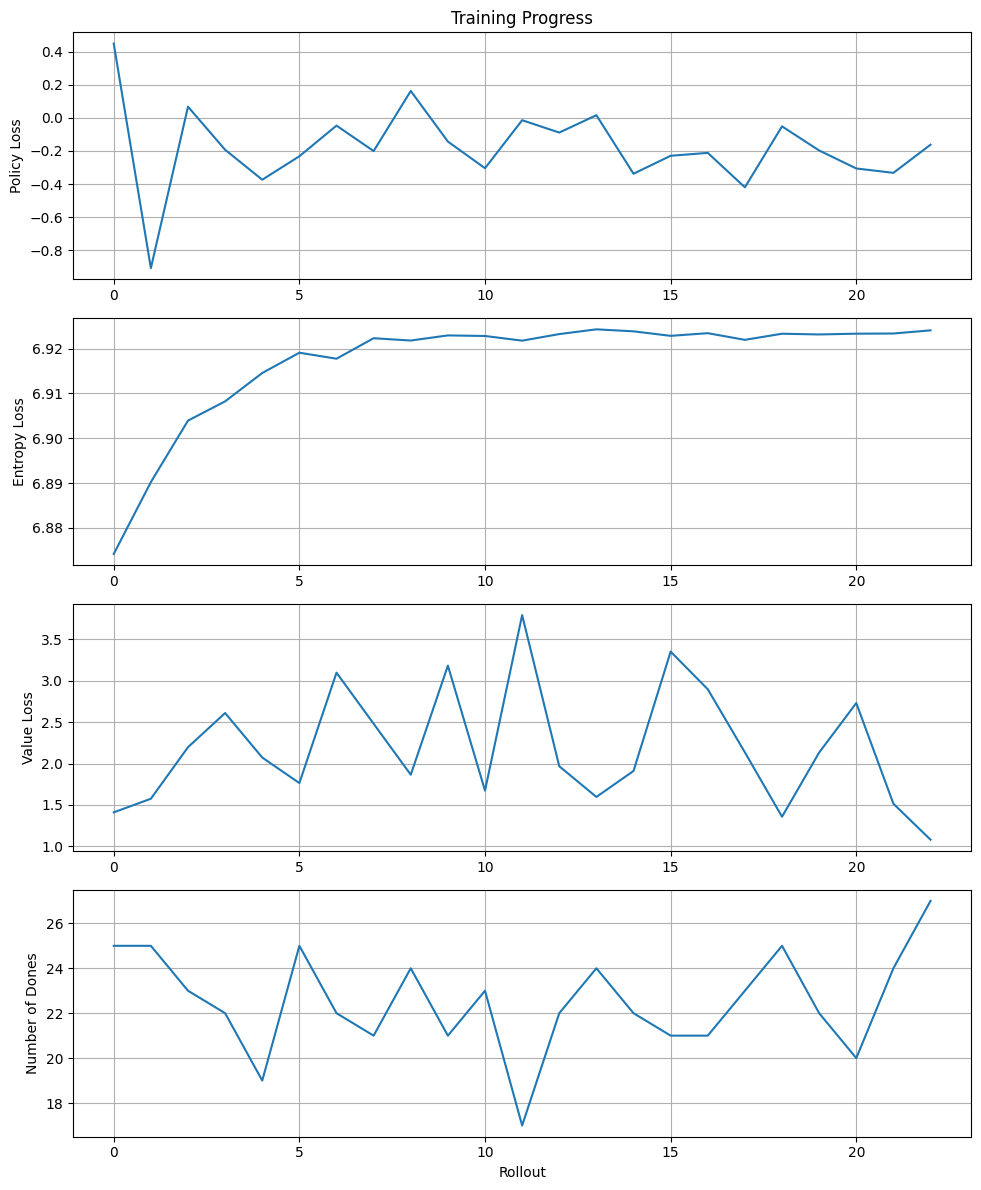

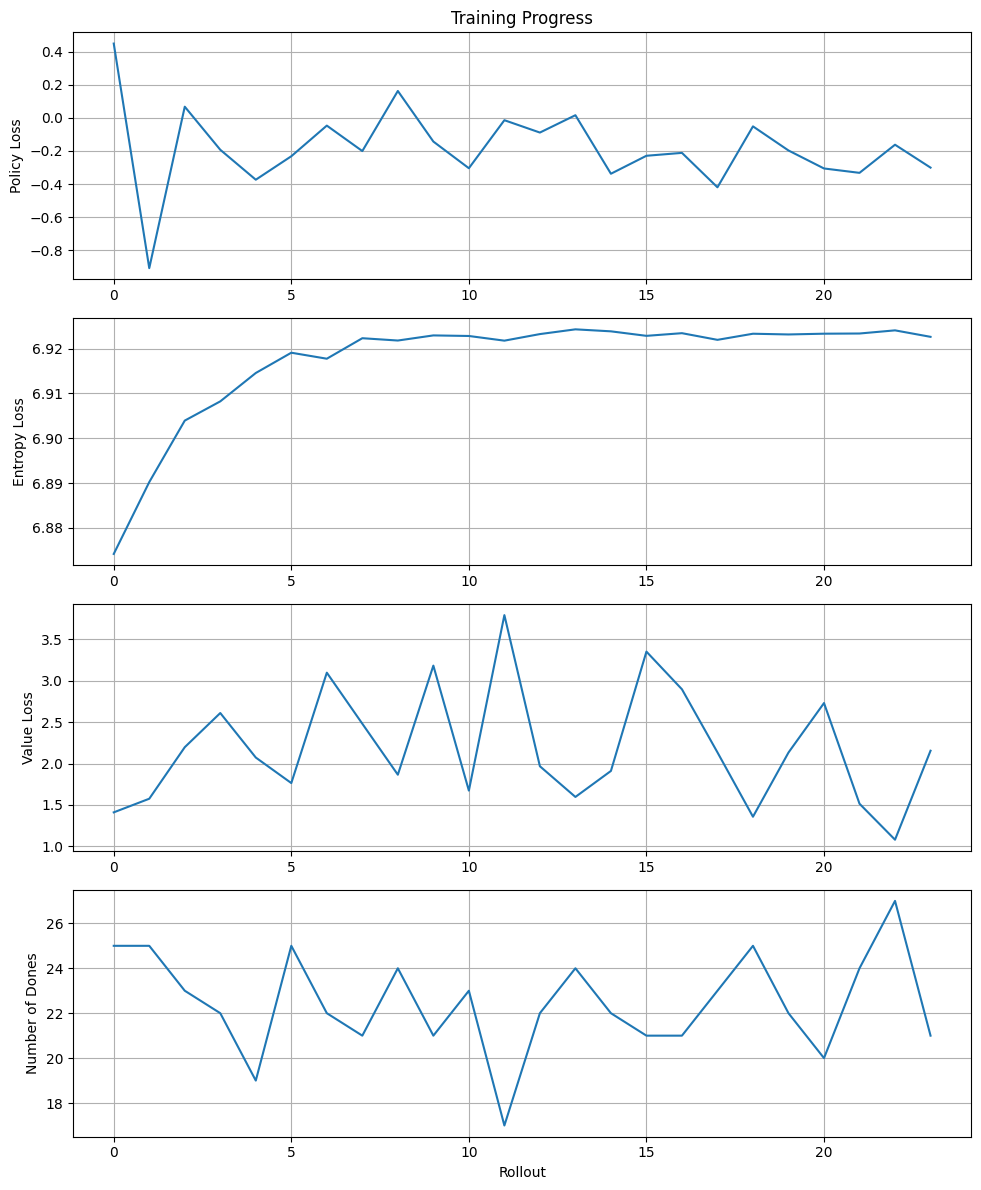

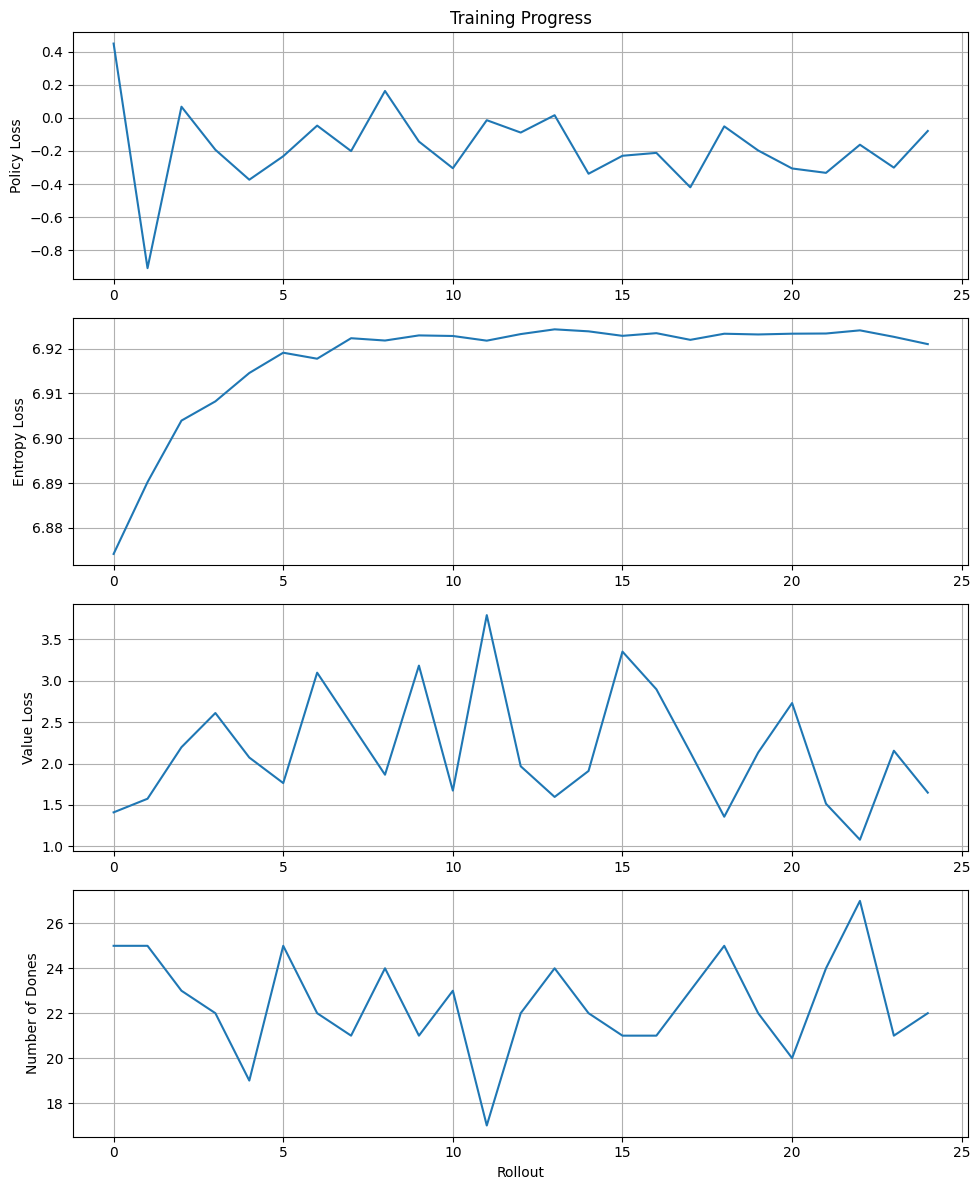

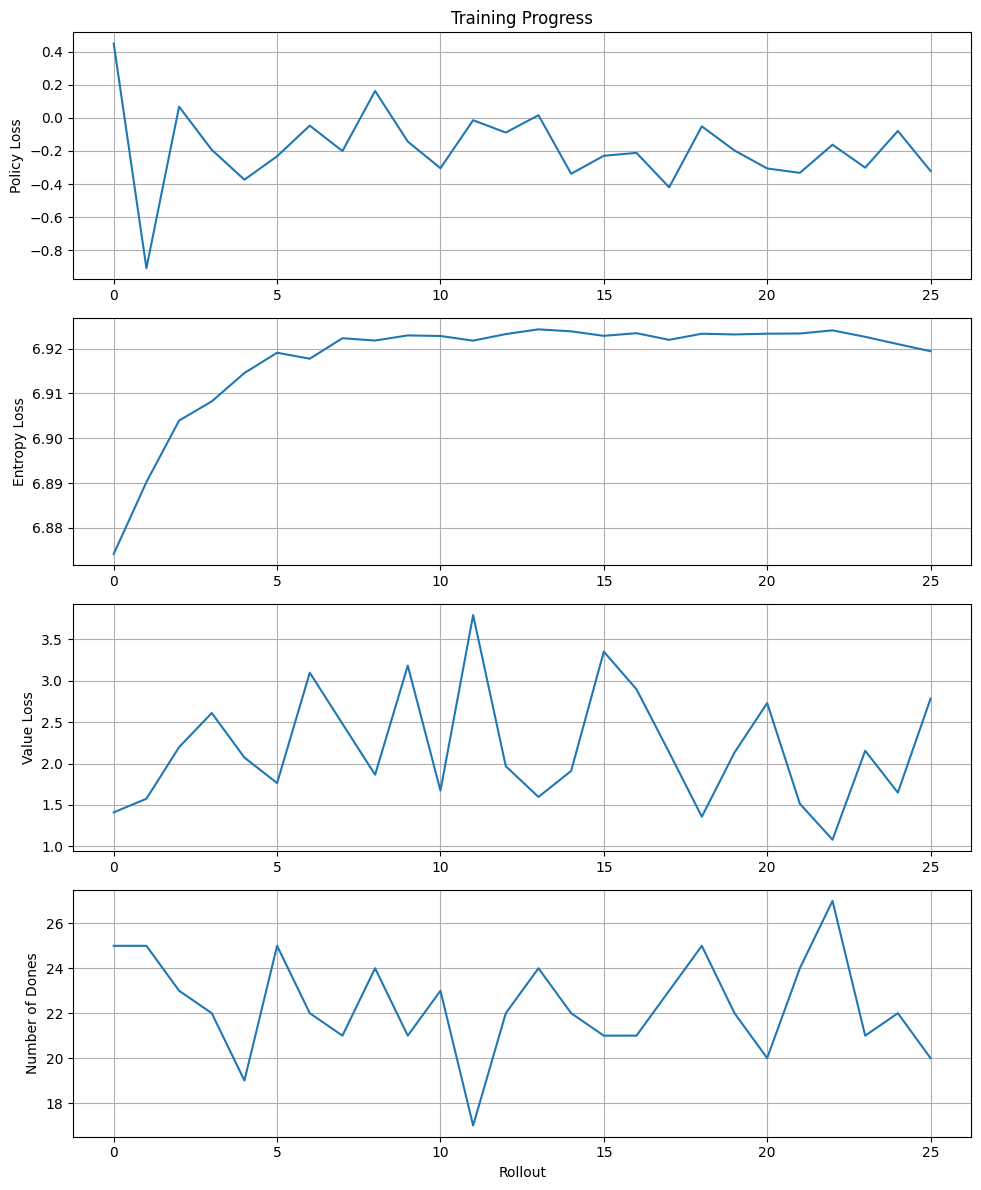

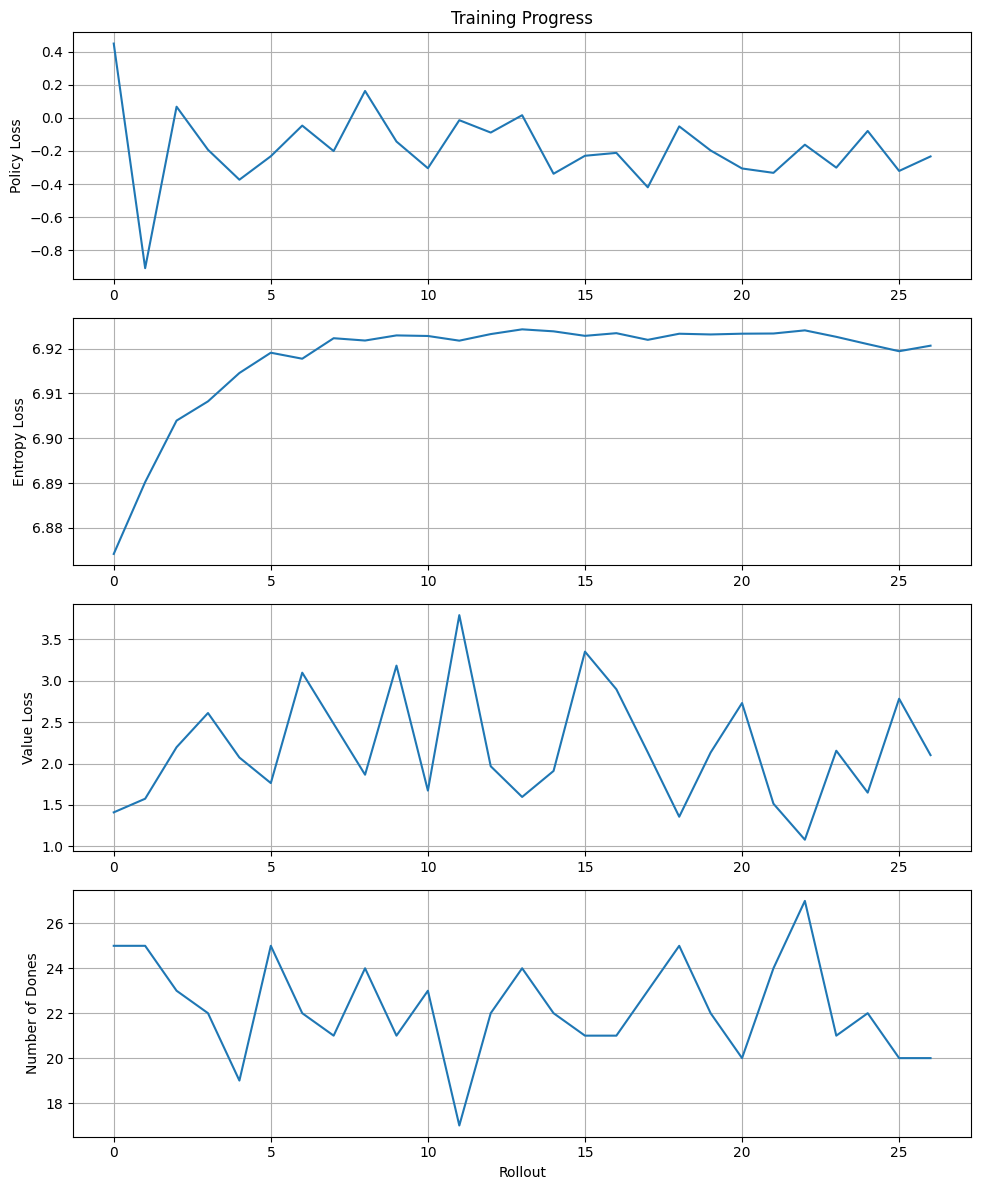

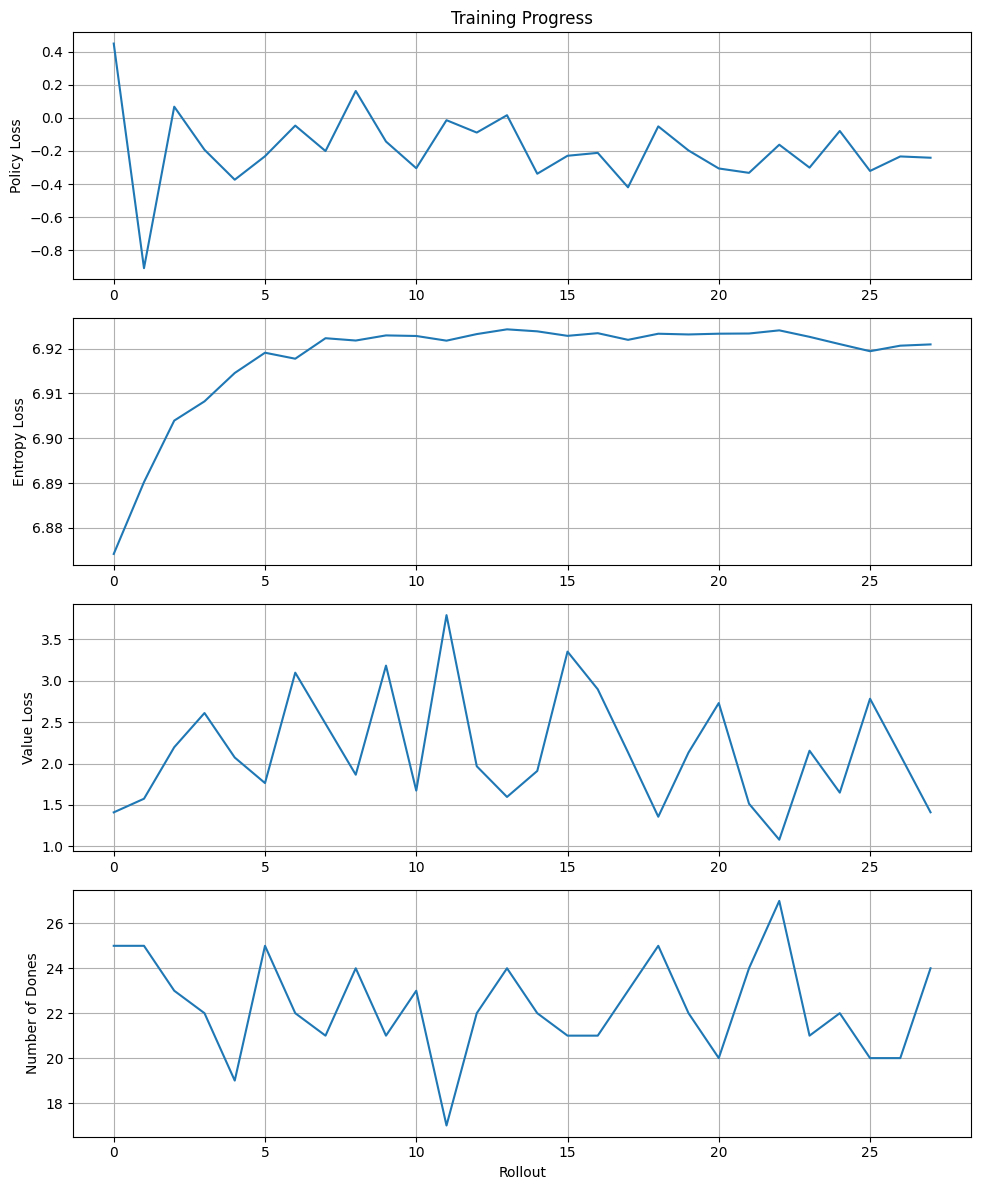

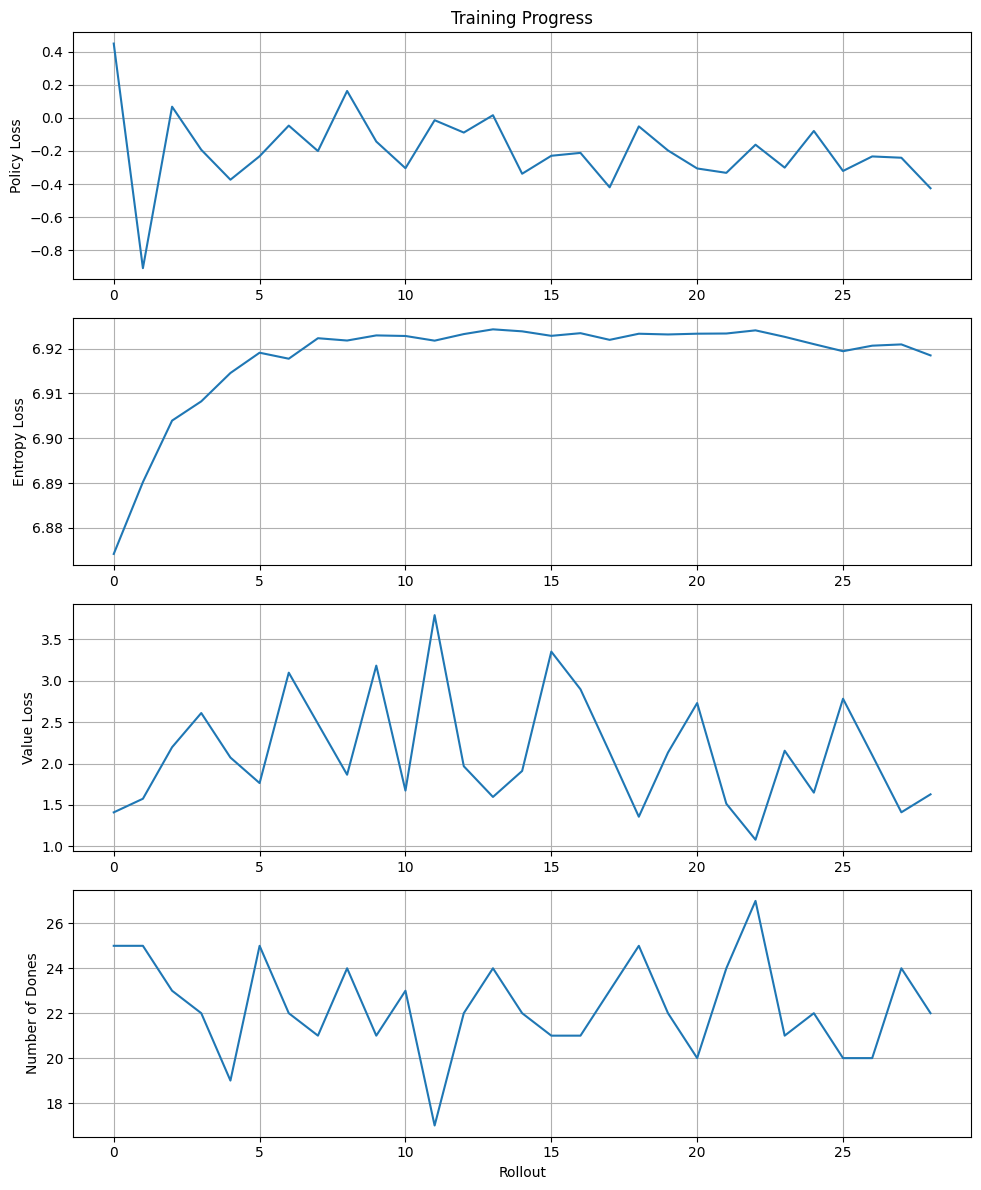

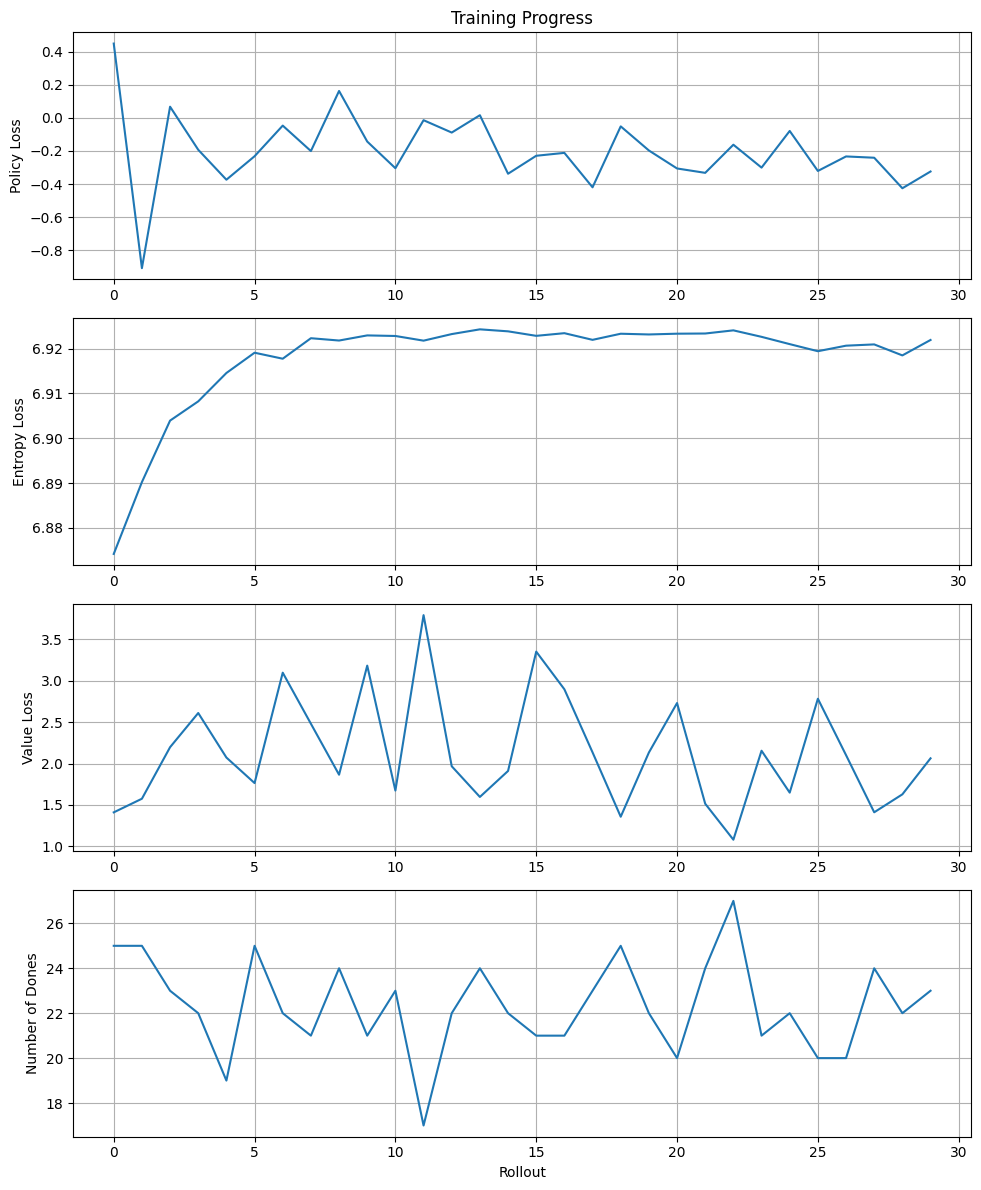

We are 7.50% of the way there!


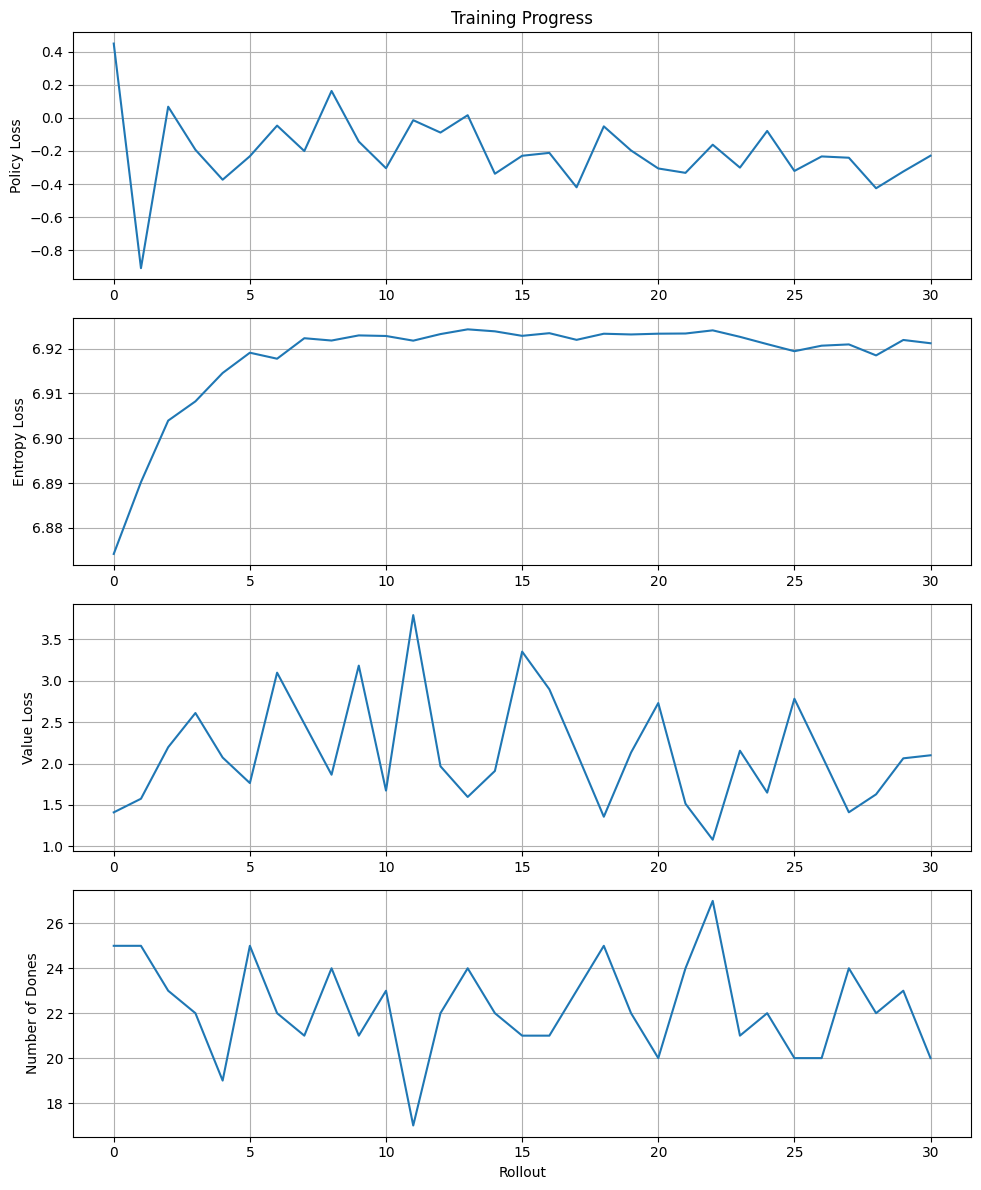

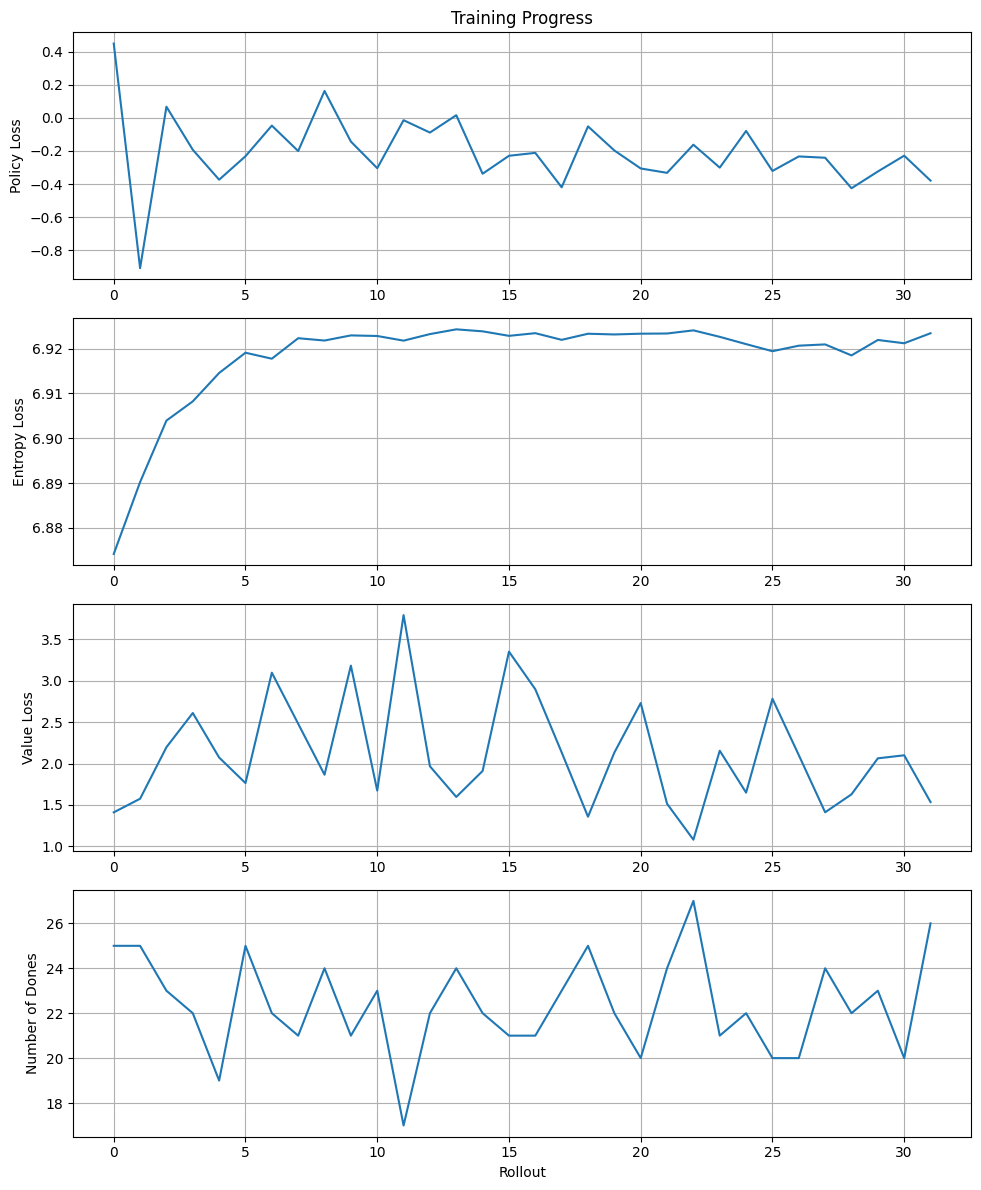

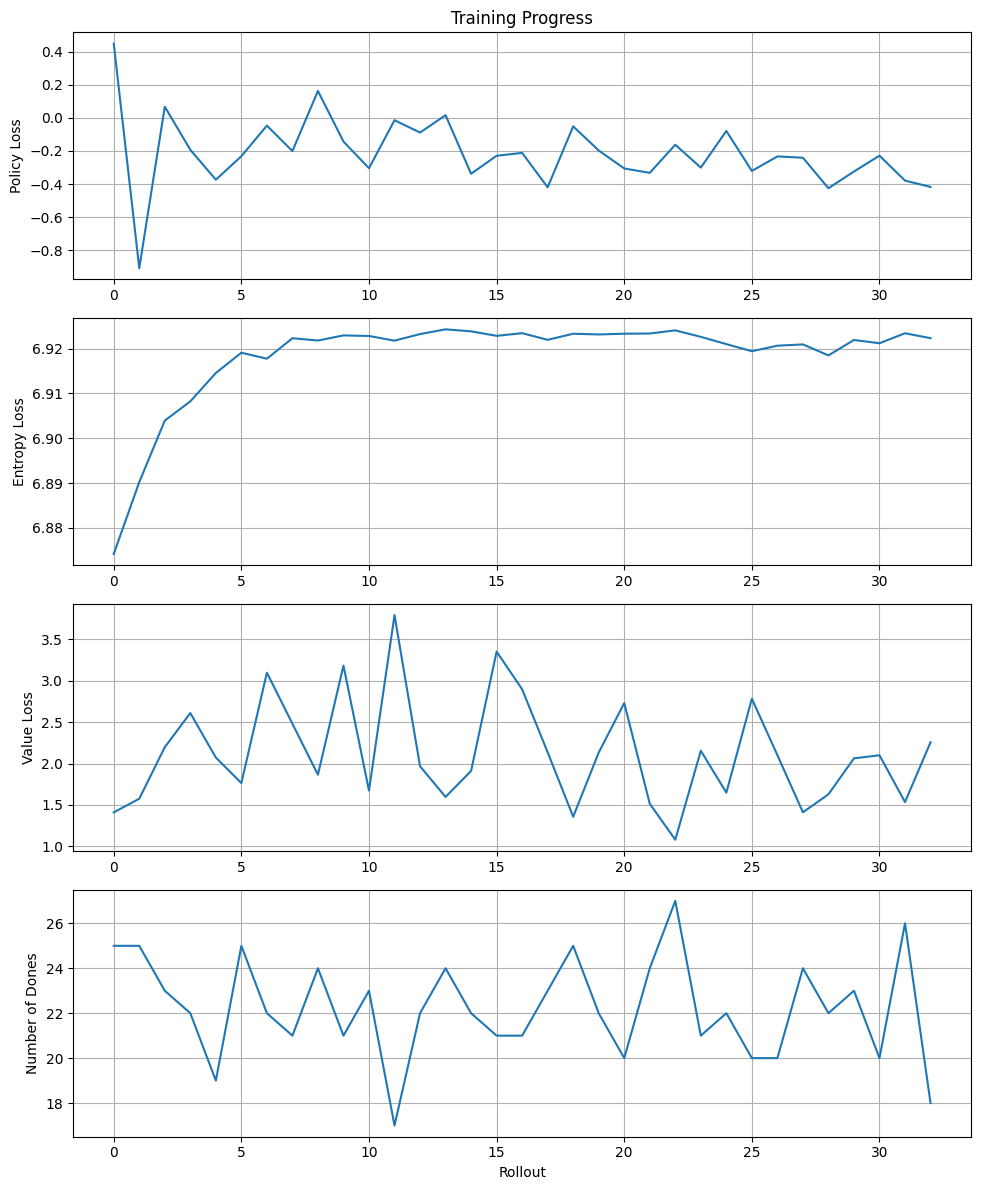

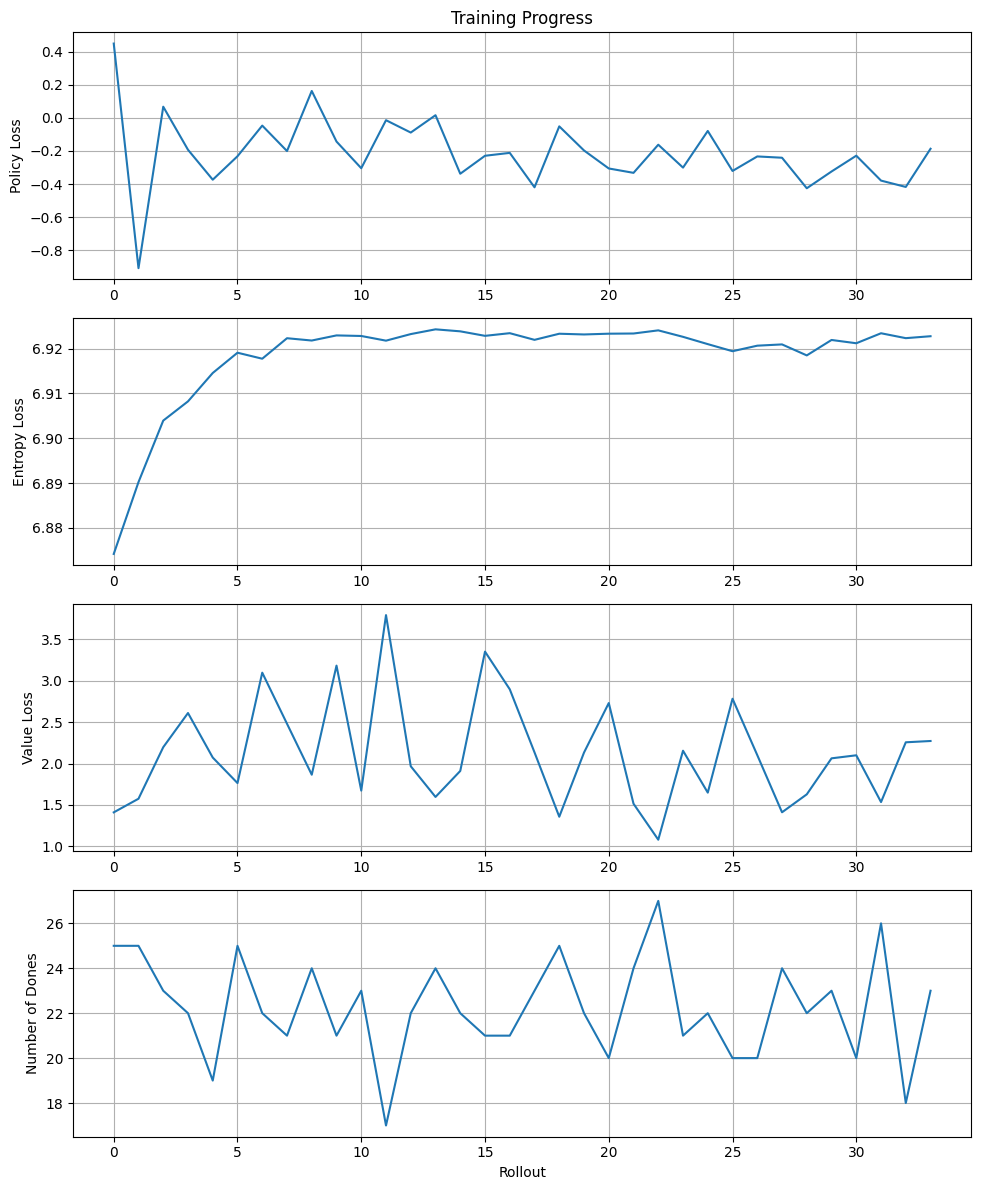

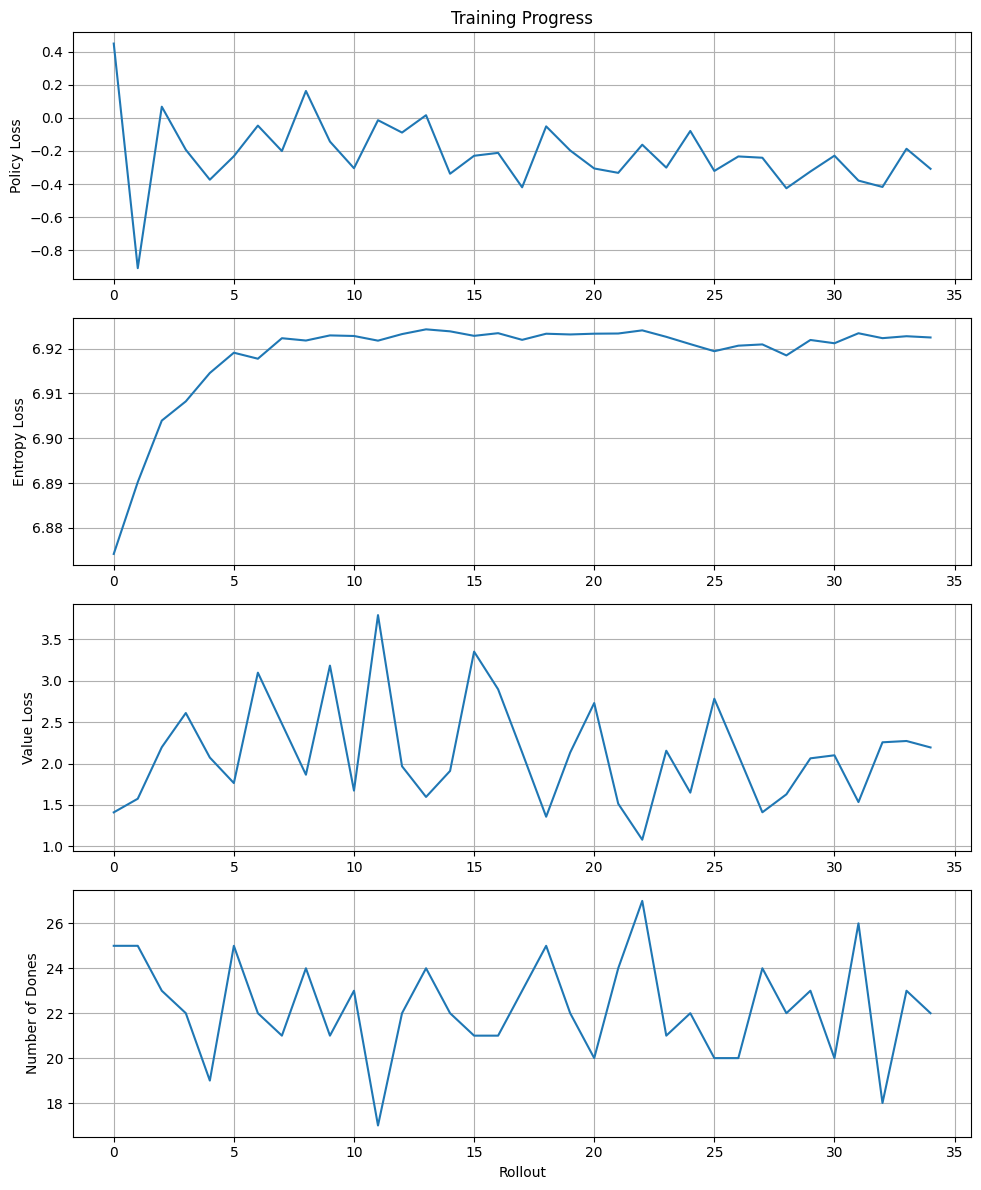

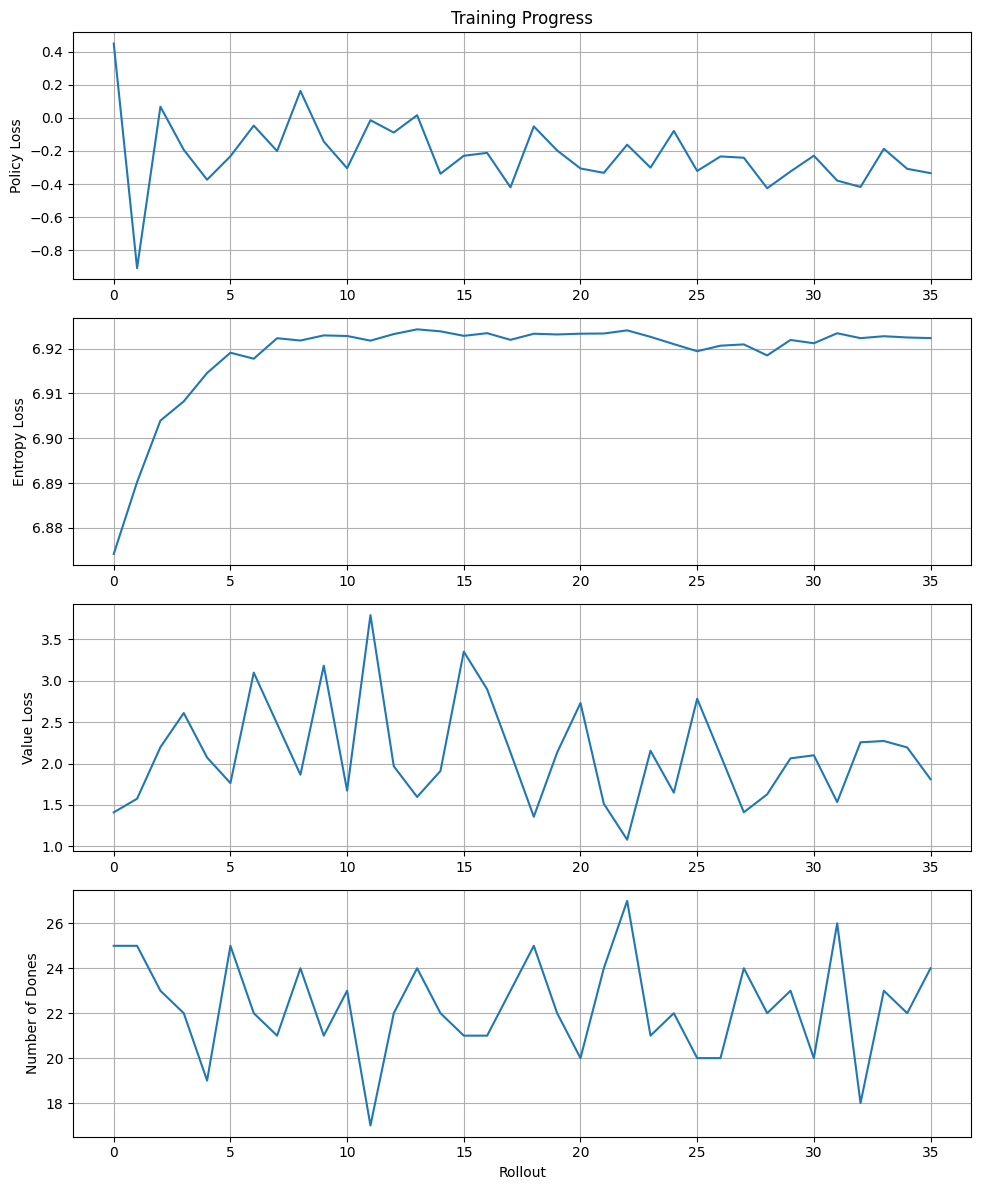

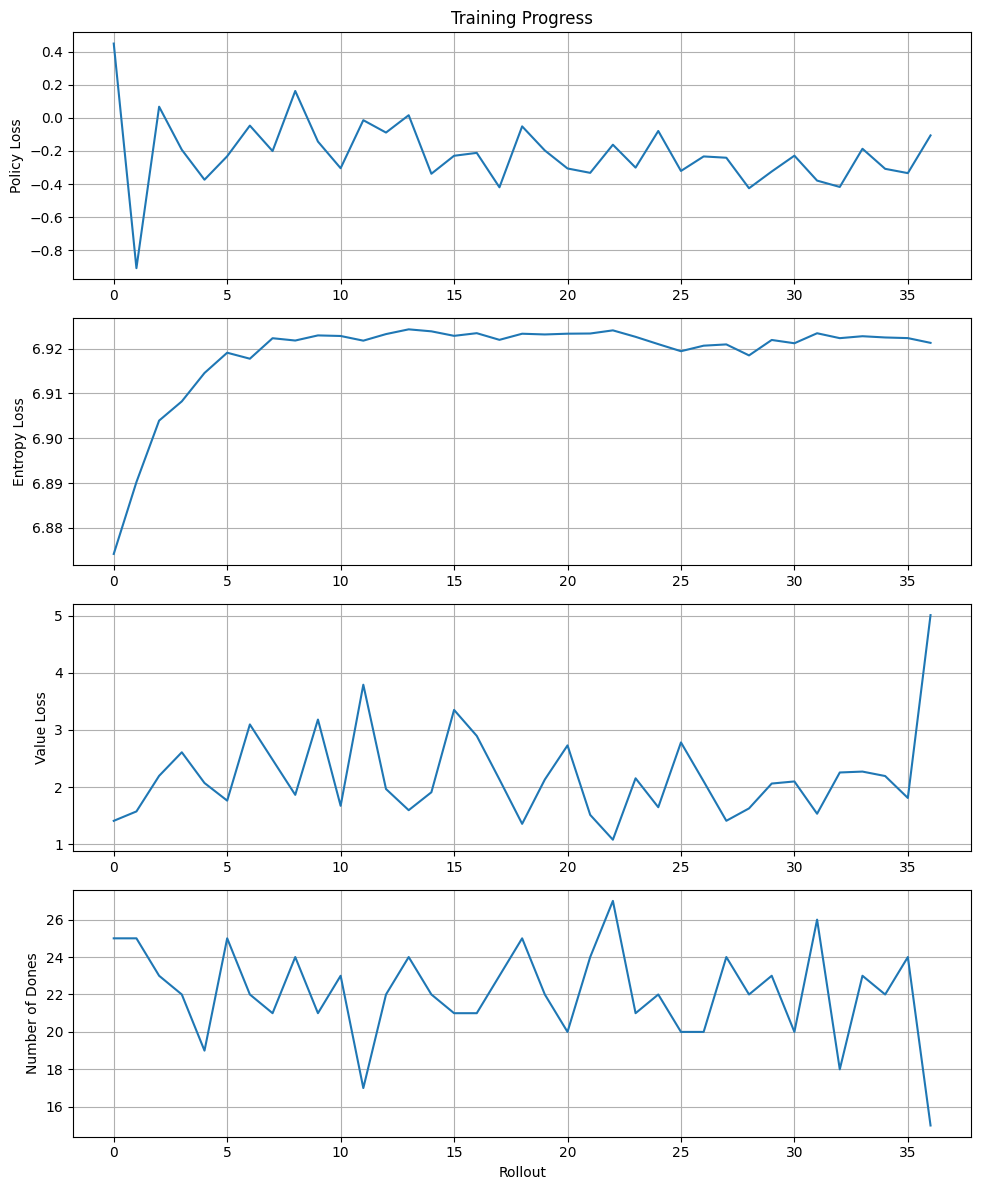

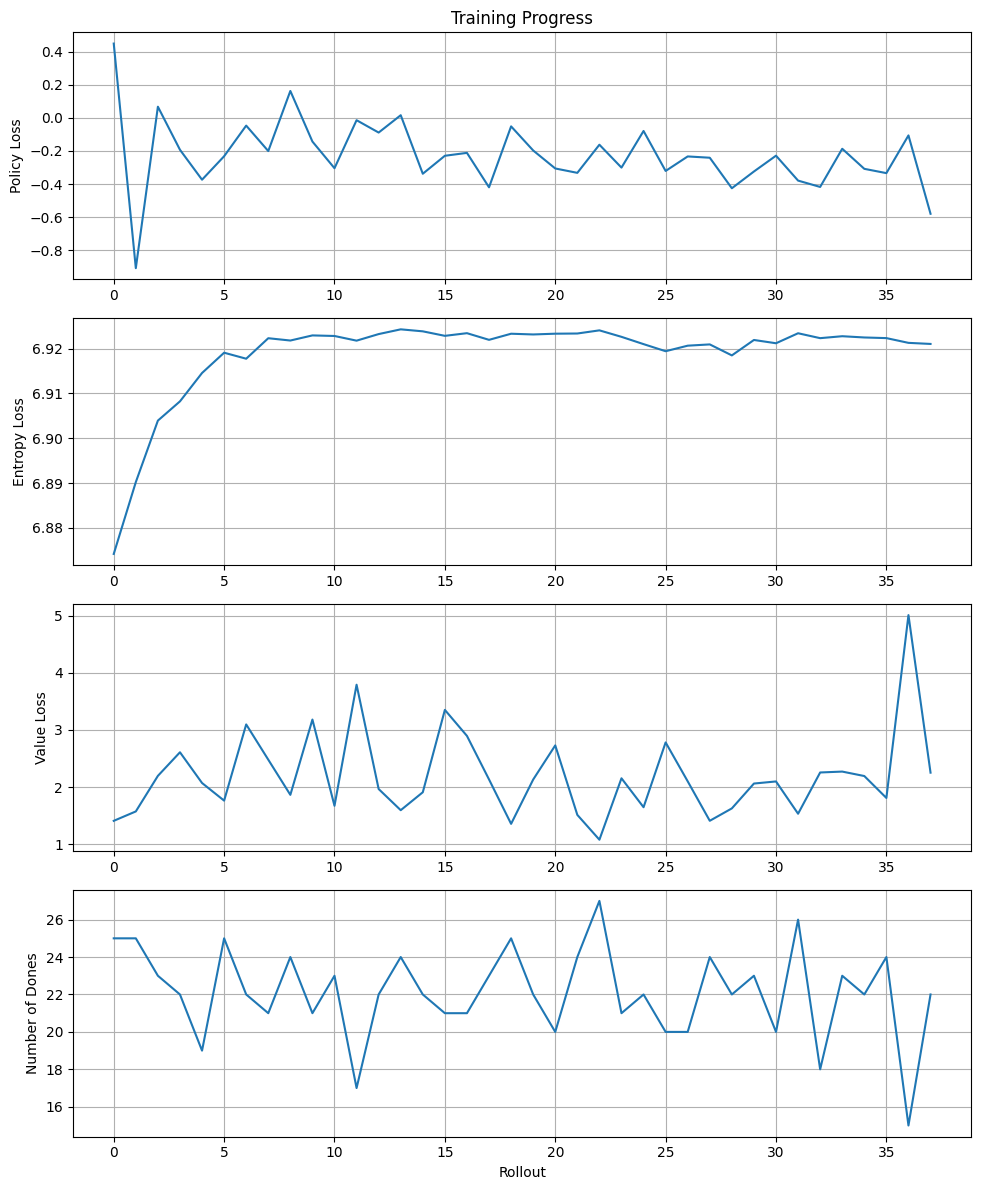

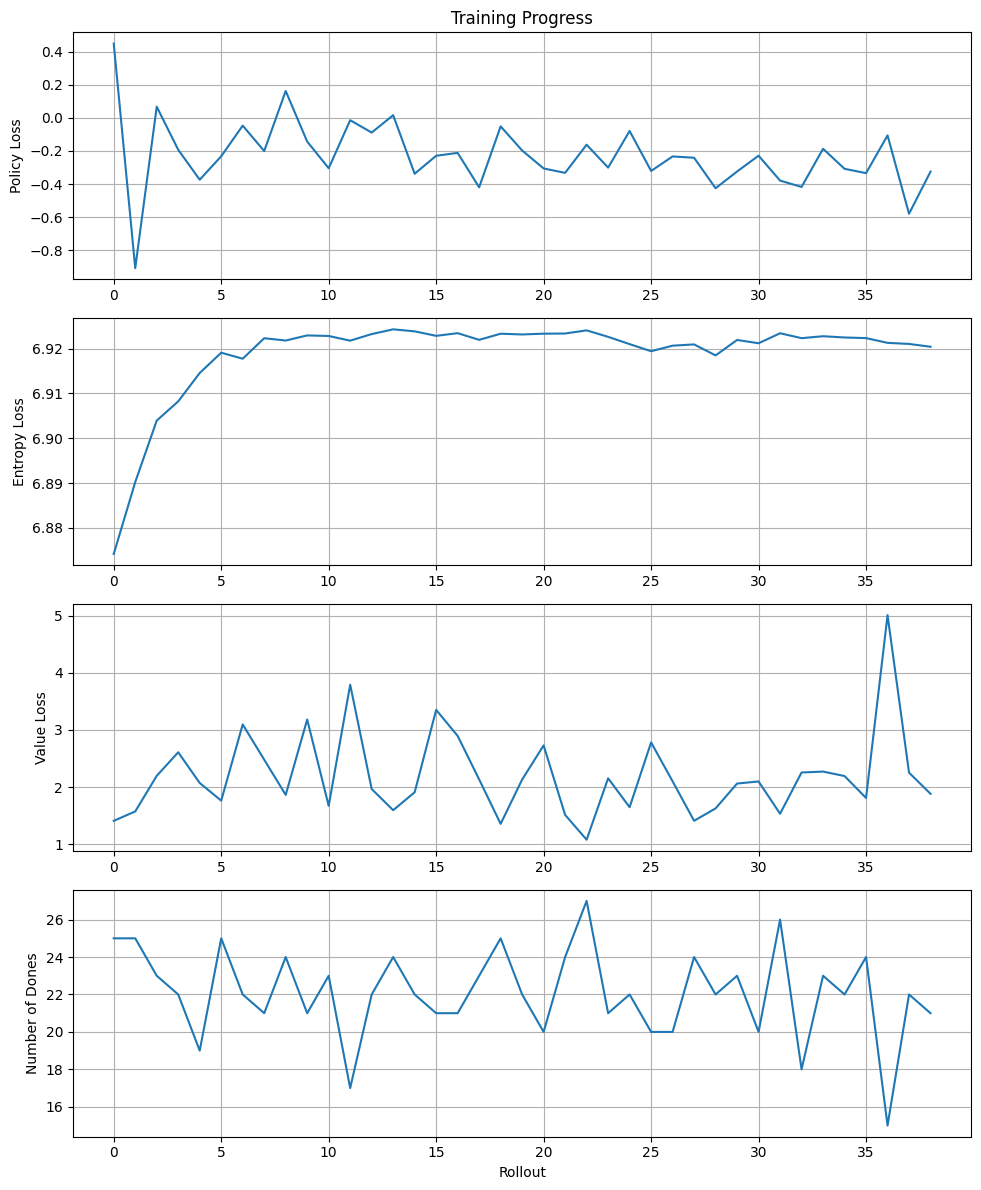

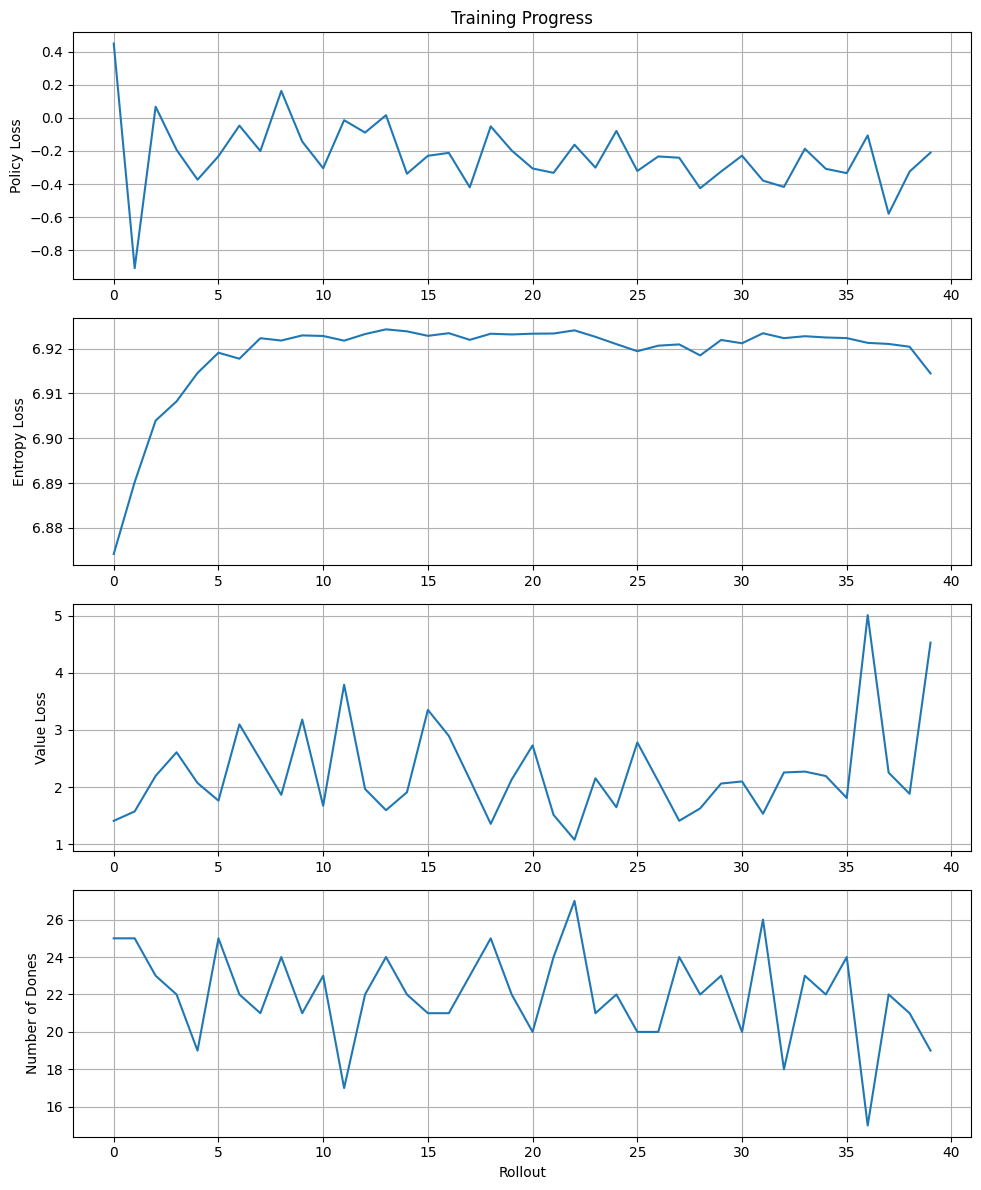

We are 10.00% of the way there!


KeyboardInterrupt: 

In [56]:
# Hper parameters

initial_learning_rate = 2.5e-4
env_id = "CartPole-v1" # going to use "CartPole-v1"
num_envs = 4
rollouts = 400
middle_layer_size = 64 # Define the size of the middle layer
batch_size = 128 # Define a batch size for reshaping
num_epochs = 4
num_mini_batches = 2
clipping_coef = 0.2

gamma = 0.99

# Conventional Vectorized Environment wrapper
def make_env(env_id, seed=None): # Added seed parameter
    def _init():
        env = gym.make(env_id)
        if seed is not None: # Set seed if provided
            env.reset(seed=seed)
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
        # Optional: Add wrappers here if needed
        return env
    return _init

# Initialize lists to store data for plotting
policy_losses = []
entropy_losses = []
value_losses = []
dones_counts = []


# Agent definition

class Agent(nn.Module):
  def __init__(self, observation_space_shape, action_space_size, middle_layer_size) -> None:
      super().__init__()

      # Actor/Policy
      self.actor = nn.Sequential(
          nn.Linear(observation_space_shape, middle_layer_size),
          nn.ReLU(),
          nn.Linear(middle_layer_size, action_space_size),
          ) # Added dim=-1 to softmax

      # Critic/Advantage NN //might need another activation function at the end.
      self.critic = nn.Sequential(
          nn.Linear(observation_space_shape, middle_layer_size),
          nn.ReLU(),
          nn.Linear(middle_layer_size, 1), # Output size of 1 for the value function
          )


  def predict(self, x, deterministic=False):
    action_logits = self.actor(x)
    if deterministic:
        action = torch.argmax(action_logits, dim=-1)
        log_prob = None  # Log probability is not well-defined for argmax
        entropy = None   # Entropy is not well-defined for argmax
    else:
        act_dist = Categorical(logits=action_logits)
        action = act_dist.sample()
        log_prob = act_dist.log_prob(action)
        entropy = act_dist.entropy() # Calculate entropy

    value_logits = self.critic(x)

    # return entropy, probabilies, and sampled action
    return (entropy, log_prob, action, value_logits) # Return entropy, probabilities, and a sampled action


if __name__ == "__main__": # Corrected __main__

  # initilizattion
  envs = gym.vector.AsyncVectorEnv([make_env(env_id, seed=(i**2)) for i in range(num_envs)]) # Pass individual seeds

  # Get observation and action space dimensions
  observation_space_shape = envs.single_observation_space.shape[0] # Assuming flat observation space
  action_space_size = envs.single_action_space.n # Assuming discrete action space

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #initialize the Agent
  agent = Agent(observation_space_shape, action_space_size, middle_layer_size).to(device) # Pass dimensions and move to device

  #initialize the optimizer
  optimizer = optim.Adam(agent.parameters(), lr=initial_learning_rate, eps=1e-5)

  # Initialize tensors with appropriate shapes
  obs = torch.zeros((batch_size, num_envs, observation_space_shape)).to(device)
  actions = torch.zeros((batch_size, num_envs)).to(device)
  logprobs = torch.zeros((batch_size, num_envs)).to(device)
  rewards = torch.zeros((batch_size, num_envs)).to(device)
  dones = torch.zeros((batch_size, num_envs)).to(device)
  pred_values = torch.zeros((batch_size, num_envs)).to(device)

  # init actual values and advantages tensor
  actual_values = torch.zeros_like(rewards).to(device)
  advantages = torch.zeros_like(rewards).to(device)


  # initializes the observation, done, the time, and the step
  start_time = time.time()
  global_step = 0

  # define training regime
  for i in range(int(rollouts)): # Cast steps to int
    # Learning rate annealing
    frac = 1.0 - (i / rollouts)
    lr_now = initial_learning_rate * frac # Anneal from initial learning rate
    optimizer.param_groups[0]['lr'] = lr_now

    if(i%10 is 0) : print(f"We are {((1-frac)*100):.2f}% of the way there!")

    step = 0 # Initialize step counter for batch
    next_obs = torch.Tensor(envs.reset()).to(device) # Corrected envs.reset()
    next_done =  torch.zeros((num_envs,)).to(device)

    for step in range(int(batch_size)):
      # get actions, observations, rewards, and dones
      with torch.no_grad(): # Added no_grad for inference
          _, log_prob, action, values_ = agent.predict(next_obs) # Renamed values to values_ to avoid conflict

      # Move data to tensors
      next_obs_np, rewards_np, next_done_np, infos =  envs.step(action.cpu().numpy()) # env step and move action to cpu

      # Moves things that were on the cpu onto the gpu
      next_obs = torch.Tensor(next_obs_np).to(device)
      next_done = torch.Tensor(next_done_np).to(device)
      reward = torch.Tensor(rewards_np).to(device)

      # Store data in tensors at the current step
      obs[step] = next_obs
      actions[step] = action
      logprobs[step] = log_prob.detach()
      rewards[step] = reward
      dones[step] = next_done
      pred_values[step] = values_.squeeze(-1).detach() # Remove the last dimension of size 1

      global_step += num_envs # Update global step

    # calculate actual values at each time step'
    with torch.no_grad(): # Calculate advantages outside the gradient tape
        for t in reversed(range(batch_size)):
          if t == batch_size - 1:
              # For the last step, if the environment is not done, use the value of the next state (from the agent's prediction)
              # Otherwise, the actual value is just the reward at this step
              nextnonterminal = 1.0 - next_done
              next_value = agent.critic(next_obs).squeeze(-1).detach() # bootstrap next value since it doesn't exsist
          else:
              # For other steps, if the environment at the next step is not done, use the value of the next state from the stored values
              # Otherwise, the actual value is just the reward at this step
              nextnonterminal = 1.0 - dones[t+1]
              next_value = actual_values[t+1]
          actual_values[t] = rewards[t] + gamma * next_value * nextnonterminal
        advantages = actual_values - pred_values.detach() # Detach pred_values here


    # Actually training the agent neural net

    # flattening the tensors for ease
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_actual_values = actual_values.reshape(-1)
    b_pred_values = pred_values.reshape(-1)

    # creates storage to see loss over time
    Policy_loss_array = [] # Initialize list to store losses for the current rollout
    Entropy_loss_array = [] # Initialize list to store losses for the current rollout
    Value_loss_array = [] # Initialize list to store losses for the current rollout

    # Iterates over the same batch a couple times for efficiency
    for epoch in range(num_epochs):

      #seperates into minibatches
      indices = np.arange(batch_size * num_envs)   # creates indicies
      np.random.shuffle(indices)        # shuffles indicies
      minibatch_indices = np.array_split(indices, num_mini_batches)

      #iterates over the minibatches
      for current_minibatch_indices in minibatch_indices: # Corrected indexing for minibatch_indices

        # init mini_batch
        mb_obs = b_obs[current_minibatch_indices]
        mb_log_probs = b_logprobs[current_minibatch_indices]
        mb_actions = b_actions[current_minibatch_indices] # Corrected indexing for mb_actions
        mb_advantages = b_advantages[current_minibatch_indices]
        mb_actual_values = b_actual_values[current_minibatch_indices]
        mb_pred_values = b_pred_values[current_minibatch_indices].detach() # Detach old predicted values for clipping


        # get new logprobs(but don't overwrite), values, and entropy
        mb_new_entropy, mb_new_log_probs, _, mb_new_values_ = agent.predict(mb_obs) # note: may need to be flattened

        # value optimization
        unclipped_value_loss = (mb_actual_values - mb_new_values_.squeeze(-1)) ** 2

        clipped_predicted_values = mb_pred_values + torch.clamp(mb_new_values_.squeeze()- mb_pred_values, -clipping_coef, clipping_coef)
        clipped_value_Loss = (mb_actual_values - clipped_predicted_values ) ** 2

        value_loss = torch.max(unclipped_value_loss, clipped_value_Loss).mean()
        value_loss = value_loss * 0.01 # adds weight to value_loss
        # policy optimization

        # Normalize advantages
        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8) # Add a small epsilon for numerical stability

        # calculate ratios
        unclipped_ratio = (mb_new_log_probs - mb_log_probs).exp()
        clipped_ratio = torch.clamp(unclipped_ratio, 1 - clipping_coef, 1 + clipping_coef)

        # calculate loss
        policy_loss = torch.max(-mb_advantages*unclipped_ratio, -mb_advantages*clipped_ratio).mean()
        policy_loss = policy_loss * 100 # adds weight to policy loss

        # calculates entropy
        entropy_loss = mb_new_entropy.mean()
        entropy_loss = entropy_loss * 10 # adds weight to entropy loss
        #calculates total loss

        loss = (policy_loss) - (entropy_loss) + (value_loss)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
        optimizer.step()
        Policy_loss_array.append(policy_loss.item()) # Append mini-batch loss to list
        Entropy_loss_array.append(entropy_loss.item()) # Append mini-batch loss to list
        Value_loss_array.append(value_loss.item()) # Append mini-batch loss to list

    # Calculate and print mean loss for the current rollout
    mean_policy_loss = np.mean(Policy_loss_array)
    mean_entropy_loss = np.mean(Entropy_loss_array)
    mean_value_loss = np.mean(Value_loss_array)

    # Store the mean losses and dones count for plotting
    policy_losses.append(mean_policy_loss)
    entropy_losses.append(mean_entropy_loss)
    value_losses.append(mean_value_loss)
    dones_counts.append(dones.sum().cpu().item())

    plot_losses(
        policy_loss=policy_losses,
        entropy_loss=entropy_losses,
        value_loss=value_losses,
        dones_counts=dones_counts)

  envs.close() # Close the environment

  # Save the agent's state dictionary
  torch.save(agent.state_dict(), "agent.pth")
  print("Agent state saved to agent.pth")

In [45]:
# Set up evaluation environment
eval_env = gym.make(env_id, render_mode='rgb_array') # Use render_mode for video recording

# Optional: Wrap the environment to record video
# You might need to install 'moviepy' and 'ffmpeg' for this.
# !pip install moviepy ffmpeg
from gym.wrappers.record_video import RecordVideo

# Create a directory to save videos
video_folder = "./eval_videos"
os.makedirs(video_folder, exist_ok=True)

eval_env = RecordVideo(eval_env, video_folder)

# Load the trained agent's state (assuming agent is still in memory or saved)
# If you saved the agent, you would load it here:
try:
    agent.load_state_dict(torch.load("agent.pth"))
    print("Agent state loaded successfully.")
except FileNotFoundError:
    print("Agent state file not found. Please run the training cell first.")
    # Optionally, handle this case by exiting or using an untrained agent
    # For now, we'll continue with the current agent instance (likely untrained if file not found)


# Set agent to evaluation mode
agent.eval()

# Run evaluation episodes
num_eval_episodes = 10 # Number of episodes for evaluation
episode_rewards = []

for episode in range(num_eval_episodes):
    obs = eval_env.reset() # Correctly unpack observation and info
    done = False
    episode_reward = 0

    while not done:
        with torch.no_grad(): # Use no_grad for inference
            # Convert observation to tensor and move to device
            obs_tensor = torch.Tensor(obs).unsqueeze(0).to(device) # Add batch dimension

            # Get action from the agent (use predict for single environment inference)
            _, _, action, _ = agent.predict(obs_tensor)

            # Remove batch dimension and move action to cpu for environment step
            # For a single discrete action, get the scalar value
            action_np = action.squeeze(0).cpu().numpy().item()


        # Step the environment
        obs, reward, terminated, truncated = eval_env.step(action_np) # Correctly unpack all 5 values
        episode_reward += reward
        done = terminated # Consider either terminated or truncated as done for episode termination


    episode_rewards.append(episode_reward)
    print(f"Evaluation Episode {episode + 1}: Reward = {episode_reward}")

# Close the evaluation environment
# Attempt to close the underlying environment directly as a workaround for potential wrapper close issues
eval_env.env.close()


# Calculate and print mean reward
mean_eval_reward = np.mean(episode_rewards)
print(f"\nMean Evaluation Reward over {num_eval_episodes} episodes: {mean_eval_reward}")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/eval_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Agent state loaded successfully.
Evaluation Episode 1: Reward = 11.0
Evaluation Episode 2: Reward = 20.0
Evaluation Episode 3: Reward = 21.0
Evaluation Episode 4: Reward = 42.0
Evaluation Episode 5: Reward = 25.0
Evaluation Episode 6: Reward = 13.0
Evaluation Episode 7: Reward = 19.0
Evaluation Episode 8: Reward = 15.0
Evaluation Episode 9: Reward = 13.0
Evaluation Episode 10: Reward = 12.0

Mean Evaluation Reward over 10 episodes: 19.1
